# 0. Import packages
A series of packages requires to be installed to run the model. These packages are designed to manage large datasets, work with spherical coordinates and present the results in suitable plots. 

In [1]:
# import packages

# numpy
import numpy                       as     np

# matplotlib
import matplotlib.pyplot           as     plt
import matplotlib                  as     mpl
import matplotlib.dates            as     mdates
from   matplotlib                  import rc
from   matplotlib.colors           import ListedColormap

# cartopy
import cartopy.crs                 as     ccrs
import cartopy.feature             as     cfeature
import cartopy.mpl.ticker          as     cticker
import cartopy.io.shapereader      as     shpreader

# shapely
import shapely.geometry            as     sgeom
from   shapely                     import geometry
from   shapely.ops                 import unary_union
from   shapely.geometry            import Polygon, Point, MultiPolygon
from   shapely.prepared            import prep

# scipy
from   scipy                       import interpolate
from   scipy.optimize              import fsolve
from   scipy.spatial               import KDTree
from   scipy.interpolate           import griddata

# data management packages
import xarray                      as     xr
import pandas                      as     pd
import geopandas                   as     gpd

# os
import os
import os.path

# remaining packages
import sys
import cmocean
import alphashape
import calendar
import fiona
import re
from   datetime                    import datetime
from   mpl_toolkits.axes_grid1     import make_axes_locatable
from   geographiclib.geodesic      import Geodesic
from   descartes                   import PolygonPatch
from   fastkml                     import kml

## 0.1. Functions
In addition, a series of general plotting functions are defined to make it more convenient to present the results.

In [10]:
def plt_base_simple(xlims,ylims,ytickspacing,xtickspacing): 
    '''
    Create base of plot
    
    Parameters
    ----------
    xlims,ylims: ax limits [deg]
    ytickspacing,xtickspacing: tick spacing [deg]
    
    Returns
    -------
    fig,ax: plot base
    
    '''
    
    fig = plt.figure() # create figure
    ax  = plt.axes(projection=ccrs.PlateCarree()) # create axis

    ax.set_extent([xlims[0],xlims[1],ylims[0],ylims[1]], ccrs.PlateCarree()) # set limits
    ax.add_feature(cfeature.LAND,facecolor=[0.95,0.95,0.95]) # add land
    ax.add_feature(cfeature.COASTLINE) # add coast
    
    ax  = tick_placer(ax,xlims,ylims,xtickspacing,ytickspacing) # place ticks
    return fig,ax

def line_cords(lat1,lon1,lat2,lon2,N=100): 
    '''
    Geodesic line between two points
    
    Parameters
    ----------
    lat1,lon1: starting coordinate [deg]
    lat2,lon2: destination coordiante [deg]
    N:         line resolution (number of points)    
    
    Returns
    -------
    plon,plat: line coordinates [deg]
    
    '''
    
    gl = Geodesic.WGS84.InverseLine(lat1,lon1,lat2,lon2) # geodesic between the two points
    S  = gl.s13 # total length of the geodesic
    ea = np.linspace(0, S, N) # total length in segments

    plon = np.empty(N) # allocate longitude
    plat = np.empty(N) # allocate latitude 

    for i in range(N): # loop over each point
        g  = gl.Position(ea[i], Geodesic.STANDARD | Geodesic.LONG_UNROLL) # get locations
        plon[i] = g['lon2'] # lonitude 
        plat[i] = g['lat2'] # latitude 
    return plon,plat

def tick_placer(ax,xlims,ylims,xtickspacing,ytickspacing): 
    '''
    Place ticks in cartopy plot
    
    Parameters
    ----------
    ax:                        axis of plot
    xlims,ylims:               longitudinal, lateral limits [deg]
    xtickspacing,ytickspacing: longitudinal, lateral tick spacing [deg]    
    
    Returns
    -------
    ax:                        axis including placed limits
    '''   
    # place x-ticks
    xticks,xticklabels = tick_single_ax(xlims,xtickspacing) # tick locations and labels
    ax.set_xticks(xticks, crs=ccrs.PlateCarree()) # set ticks
    ax.set_xticklabels(xticklabels) # set tick labels

    # place y-ticks
    yticks,yticklabels = tick_single_ax(ylims,ytickspacing) # tick locations and labels
    ax.set_yticks(yticks, crs=ccrs.PlateCarree()) # set ticks
    ax.set_yticklabels(yticklabels) # set tick labels
    return ax

def tick_single_ax(lims,tickstep,dropticksmid = False): 
    '''
    Create ticks and ticklabels for tick_placer() for a single ax
    
    Parameters
    ----------
    lims:         tick outer limits [deg]
    tickstep:     tick spacing [deg]
    dropticksmid: drop middle ticks when True    
    
    Returns
    -------
    ticks:        tick locations [deg]
    ticklables:   ticklabels [deg]    
    '''   
    ticks       = np.arange(np.ceil(lims[0]/tickstep)\
                  *tickstep,np.floor((lims[1])/tickstep+1)\
                  *tickstep,tickstep) # range of ticks
    tickstepstr = str(tickstep) # ticks to dring
    ticksdec    = tickstepstr[::-1].find('.') # find decimal numbers
    if ticksdec < 0: # if no decimal numbers
        ticksdec = 0 # zero decimal numbers
    ticklabels  = [("%."+str(ticksdec)+"f"+"$^\circ$") % number for number in ticks] # make tick labels
    if dropticksmid: # when mid ticks are dropped
        ticklabels[1:-1] = [' '] * len(ticklabels[1:-1]) # drop mid ticks
    return ticks,ticklabels # place ticks along axis

def plt_modified_imshow(X,Y,Z,ax=None,cb=False,*args,**kwargs): # modified plt.imshow
    '''
    Modified plt.imshow that automatically includes colorbar 
    
    Parameters
    ----------
    X,Y:    meshgrid of x and y values [Nx*Ny]
    Z:      data of interest 2D matrx [Nx*Ny]
    ax:     ploting axis
    cb:     include colorbar when true
    args:   arguments for plt.imshow
    kwargs: kwargs for plt.imshow    
    
    Returns
    -------
    im:     modified plt.imshow     
    ''' 
    
    # draw modified imshow
    dx = (X[0,1]-X[0,0])/2 # spacing along x
    dy = (Y[1,0]-Y[0,0])/2 # spacing along y
    extent = [X[0,0]-dx, X[0,-1]+dx, Y[0,0]-dy, Y[-1,0]+dy] # extent imshow to correct size
    if ax is None: # if no ax is included
        ax = plt.gca() # create axis
    im = ax.imshow(np.flip(Z,axis=0), extent=extent,*args,**kwargs) # draw imshow  
    
    # plot colorbar
    if cb: 
        # data min and max
        zmin = np.nanmin(z) # minimum of data 
        zmax = np.nanmax(z) # maximum of data
        
        # get vmin value
        if 'vmin' in kwargs.keys(): # check if vmin is stated
            vmin = kwargs['vmin'] # get vmin value
        else: # if not stated
            vmin = zmin # set vmin from data

        # get vmax value
        if 'vmax' in kwargs.keys(): # check if vmax is stated
            vmax = kwargs['vmax'] # get vmax value
        else: # if not stated
            vmax = zmax # set vmax from data

        # determine extension of colorbar 
        if (zmin>=vmin) & (zmax<=vmax):
            extend = 'neither'
        elif (zmax>vmax) & (zmin<vmin):
            extend = 'both'
        elif zmax>vmax:
            extend = 'max'
        elif zmin<vmin:
            extend = 'min'
            
        # create colorbar on new axis
        cax  = fig.add_axes([ax.get_position().x1+0.015,ax.get_position().y0,0.02,ax.get_position().height]) # create axis for colorbar
        plt.colorbar(im,cax=cax,extend=extend) # plot colorbar
    return im

def alpha_shape_opt(points2d,alpha_step = 0.1,fix_alpha = None):
    '''
    Single alpha shape with no outliers (if alpha is not fixed) 
    
    Parameters
    ----------
    points2d:   points in 2D (N,2)
    alpha_step: increase alpha from 0 by alpha_step each iteration
    fix_alpha:  fix alpha to single value
        
    Returns
    -------
    border:     outer points
    idx:        indexes of points2d that are outer points
    shape:      
    '''  
    if fix_alpha == None: # if alpha is not fixed, then find the lowest alpha which doesn't cause outliers
        alpha       = 0 # intialize alpha
        alpha_shape = alphashape.alphashape(points2d, alpha) # get alpha shape
        polytype    = type(alpha_shape).__name__ # get type of shape
        all_in      = np.all(np.array([Point(points2d[i,:]).intersects(alpha_shape) for i in range(points2d.shape[0])])) # check if all points are intersecting with shape

        flag = False # track if alpha increased

        # start increasing alpha while making sure there remains only one shape and all point remaing intersecting
        while (polytype == 'Polygon') & (all_in == True): # check if conditions hold
            alpha      += alpha_step # increase alpha
            alpha_shape = alphashape.alphashape(points2d, alpha) # create new alpha shape
            polytype    = type(alpha_shape).__name__ # check type
            all_in      = np.all(np.array([Point(points2d[i,:]).intersects(alpha_shape) for i in range(points2d.shape[0])])) # check points intersecting shape
            flag        = True # set equal to true as alpha increas
        if flag: # when alpha increased
            alpha      -= alpha_step # remove one step of alpha 
            alpha_shape = alphashape.alphashape(points2d, alpha) # get alpha shape
    else: # if alpha is fixed
            alpha      = fix_alpha # set alpha equal to fix_alpha (given as optional input)
            alpha_shape = alphashape.alphashape(points2d, alpha) # get alpha shape

    idx     = np.array([Point(points2d[i,:]).touches(alpha_shape) for i in range(points2d.shape[0])]) # found indexes that are the edge of the alpha shape
    border  = points2d[idx] # get outline coordinates of shape
    shape   = alpha_shape # get shape
    return border,idx,shape

# 1. Departure and destination locations
This section calculates the distance between the selected starting and destination locations. In addition, an overview plot of locations and shortest routes is provided. Lastly, the allowed rowing region is defined (e.g. limitation of rowing domain).

## 1.1. Functions
To calculate the distances between coordinates and to define the allowed rowing domain.

In [3]:
def dis_cord(lat1,lon1,lat2,lon2): 
    '''
    Distance between coordinates
    
    Parameters
    ----------
    lat1,lon1: starting coordinate [deg]
    lat2,lon2: destination coordiante [deg]   
    
    Returns
    -------
    dis:       distance [m]
    
    ''' 
    dis = Geodesic.WGS84.Inverse(lat1,lon1,lat2,lon2)['s12']
    return dis

def dis_matrix(dfSloc,dfEloc): 
    '''
    Calculate distances between starting and destination locations
    
    Parameters
    ----------
    dfSloc: dataframe of starting coordinates [deg]
    dfEloc: dataframe of destintion coordinates [deg]    
    
    Returns
    -------
    dfDis:  dataframe of distance matrix [m]
    
    '''
    lat1,lat2 = np.meshgrid(dfSloc.lat.values,dfEloc.lat.values) # combine latitudes start and destination locations
    lon1,lon2 = np.meshgrid(dfSloc.lon.values,dfEloc.lon.values) # combine longitudes start and destination locations

    dis   = np.vectorize(dis_cord)(lat1,lon1,lat2,lon2) # distance between locations [m]
    dfDis = pd.DataFrame(np.swapaxes(dis,0,1)/1000,index=dfSloc.start_loc,columns=dfEloc.end_loc) # create dataframe - distance between locations [km]
    return dfDis

def create_domain(): 
    '''
    Create allowed domain to row   
    
    Returns
    -------
    Shapely MultiPolygon of allowed rowing domain
    
    '''    
    # define domain
    dom  = np.array([[40   ,-38  ],\
                     [35   ,-30  ],\
                     [35   ,-2   ],\
                     [95   ,-2   ],\
                     [102  ,-8   ],\
                     [113  ,-10  ],\
                     [122.5,-13.5],\
                     [122.5,-30  ],\
                     [115  ,-34  ],\
                     [110  ,-38  ]]) # coordinates domain (lon,lat) [deg]
    pdom = geometry.Polygon([[p[0], p[1]] for p in dom]) # create polygon

    # remove certain zones
    dom_excl  = np.array([[49.6 ,-15.2],\
                          [50.42,-16.1],\
                          [49.84,-17.2],\
                          [49.11,-17.19]]) # small cove Madagascar 
    pdom_excl = geometry.Polygon([[p[0], p[1]] for p in dom_excl]) # create polygon
    pdom      = pdom.difference(pdom_excl) # remove from domain

    # remove land from zones
    land_shp_fname = shpreader.natural_earth(resolution='50m',category='physical', name='land') # load in land
    land_geom      = unary_union(list(shpreader.Reader(land_shp_fname).geometries())) # get geometry 
    pdom           = pdom.difference(land_geom) # remove from domain
    return pdom

## 1.2. Analysis
Present the rowing distances and allowed rowing domain.

In [4]:
# convert m/s to kts
tokts = 1.94384449 # convert m/s to kts

# starting locations
dfSloc = pd.DataFrame({'start_loc':["Fremantle","Geraldton","Kalbarri","Carnarvon","Exmouth" ,"Broome"  ],
                       'lat'      :[-32.056946 ,-28.782387 ,-27.711053,-24.883717 ,-21.930724,-17.951221],
                       'lon'      :[115.743889 ,114.607513 ,114.164536,113.656956 ,114.122389,122.244327]})

# destination locations
dfEloc = pd.DataFrame({'end_loc':["Dar es Salaam"],
                       'lat'    :[-6.766305      ],
                       'lon'    :[39.195973      ]})

# distance matrix
dfDis = dis_matrix(dfSloc,dfEloc)

# display dataframes
display(dfSloc)
display(dfEloc)
display(dfDis)

,start_loc,lat,lon
0,Fremantle,-32.056946,115.743889
1,Geraldton,-28.782387,114.607513
2,Kalbarri,-27.711053,114.164536
3,Carnarvon,-24.883717,113.656956
4,Exmouth,-21.930724,114.122389
5,Broome,-17.951221,122.244327


,end_loc,lat,lon
0,Dar es Salaam,-6.766305,39.195973


end_loc,Dar es Salaam
start_loc,
Fremantle,8349.927737
Geraldton,8233.916639
Kalbarri,8188.651414
Carnarvon,8135.141605
Exmouth,8184.562517
Broome,9054.516380


C:\Users\23513098\Anaconda3\lib\site-packages\descartes\patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +
C:\Users\23513098\Anaconda3\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


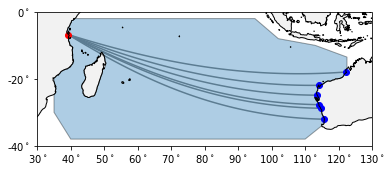

In [5]:
pdom = create_domain() # create allowed domain to row

# load land map
land_shp_fname = shpreader.natural_earth(resolution='50m',category='physical', name='land') # load in land
land_geom      = unary_union(list(shpreader.Reader(land_shp_fname).geometries())) # get geometry 
land           = prep(land_geom) # get land

# create figure of domain, including start and ending destinations
xlims = [30,130] # longitude limits [deg]
ylims = [-40,0] # latitude limits [deg]
fig,ax = plt_base_simple(xlims,ylims,20,10) # create figure

[ax.add_patch(PolygonPatch(pdom.geoms[0], alpha=0.2)) for i in range(len(pdom.geoms))] # plot rowing domain

# plot starting and destination locations 
for i in range(len(dfSloc)): # loop over all starting locations
    start_lat = dfSloc.lat.iloc[i] # start latitude [deg]
    start_lon = dfSloc.lon.iloc[i] # start longitude [deg]
    plt.scatter(start_lon,start_lat,color='blue') # add starting locations
    
for j in range(len(dfEloc)): # loop over all ending locations
    end_lat   = dfEloc.lat.iloc[j] # end latitude [deg]
    end_lon   = dfEloc.lon.iloc[j] # end longitude [deg]
    plt.scatter(end_lon,end_lat,color='red') # add ending locations
    for i in range(len(dfSloc)): # loop over all starting locations
        start_lat = dfSloc.lat.iloc[i] # start latitude [deg]
        start_lon = dfSloc.lon.iloc[i] # start longitude [deg]
        plon,plat = line_cords(start_lat,start_lon,end_lat,end_lon,N=100) # calculate geodesic distance 
        plt.plot(plon,plat,color='grey',zorder=0,transform=ccrs.Geodetic()) # plot line
plt.show()

# 2. hindcast data 
Load data of wind speeds, waves and currents. In addition, make overview plots per month of the hindcast. 

## 2.1. Load hindcast data
Load in netcdf files stored locally. Note that the there is a fault in the wind speeds direction that needs to be corrected.

In [6]:
# load datasets
dswind  = xr.open_dataset('Data/CERSAT-GLO-REP_WIND_L4-OBS_FULL_TIME_SERIE_1648775425193.nc').load()
dswaves = xr.open_dataset('Data/cmems_obs-wave_glo_phy-swh_my_multi-l4-2deg_P1D_1648776708969.nc').load()
dswater = xr.open_dataset('Data/nemo_monthly_mean.nc').load()

# correct wind dataset (wrong direction of winds)
dswind = dswind.rename_vars(eastward_wind='northward_wind1')
dswind = dswind.rename_vars(northward_wind='eastward_wind')
dswind = dswind.rename_vars(northward_wind1='northward_wind')

## 2.2. Analysis
Show montly averages of wind, air speeds and wave heights.

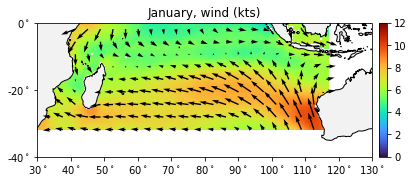

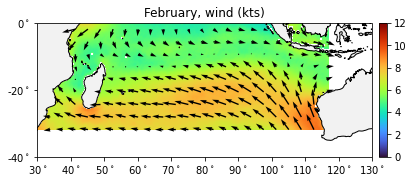

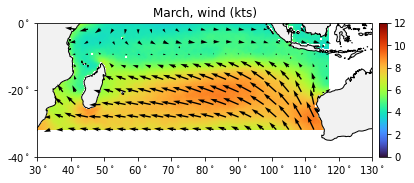

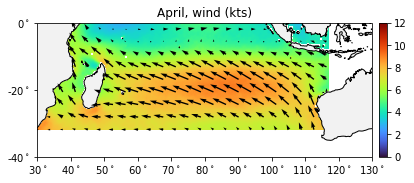

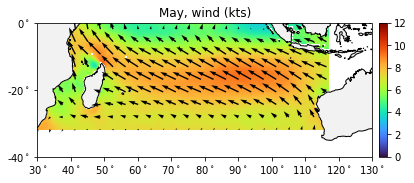

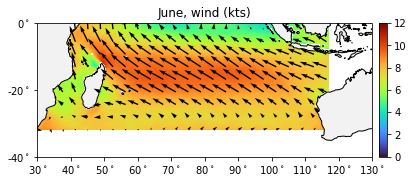

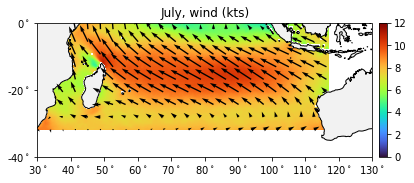

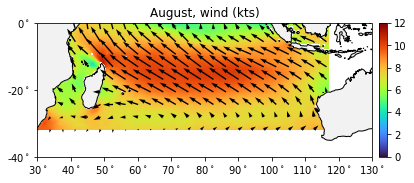

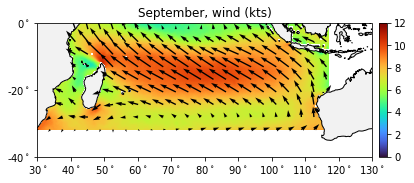

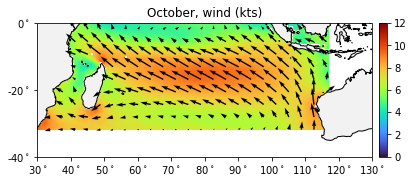

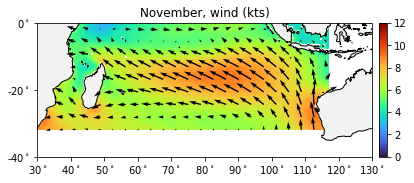

In [7]:
# plot average wind speed per month
t = dswind.time.values # get time series
for nmonth in range(1,12):
    lat  = dswind.latitude.values # latitude values
    lon  = dswind.longitude.values # longitude values
    x,y  = np.meshgrid(lon,lat) # create meshgrid of longitude and latitude
    
    tidx = (t.astype('datetime64[M]').astype(int) % 12 + 1)==nmonth # get time idx of specific month
    ua   = np.mean(dswind.northward_wind[tidx,0,:,:].values,axis=0)*tokts # longitudinal velocities
    va   = np.mean(dswind.eastward_wind[tidx,0,:,:].values,axis=0)*tokts # latereal velocities
    z    = np.mean(dswind.wind_speed[tidx,0,:,:],axis=0) # air speeds

    
    fig,ax = plt_base_simple(xlims,ylims,20,10) # create plot base
    im = plt_modified_imshow(x,y,z,ax,cb=True,cmap='turbo',interpolation='bilinear',vmin=0,vmax=12) # draw imshow
    idx = 15 # quiver step
    ax.quiver(x[::idx,::idx],y[::idx,::idx],ua[::idx,::idx],va[::idx,::idx],units='xy',scale_units='xy',scale=3) # draw quiver
    ax.set(xlim=xlims,ylim=ylims,title=calendar.month_name[nmonth]+', wind (kts)') # set labels
    plt.show()

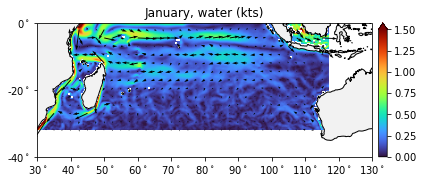

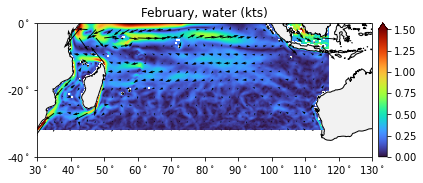

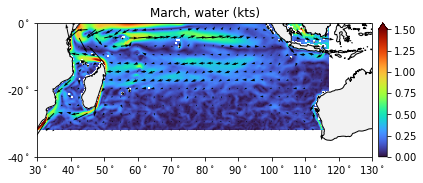

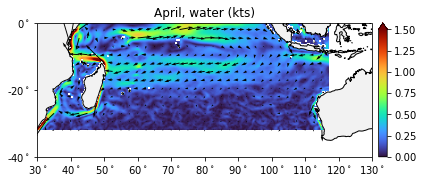

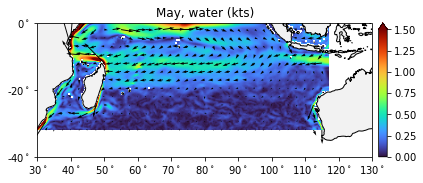

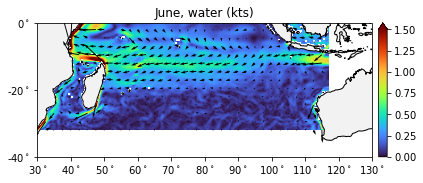

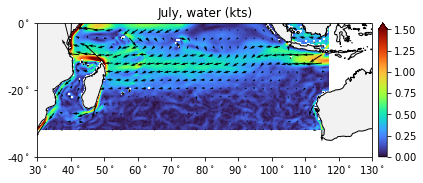

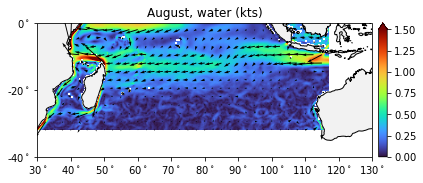

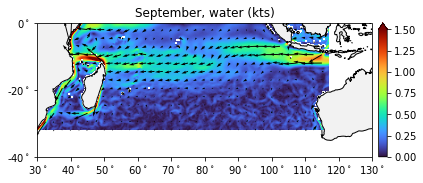

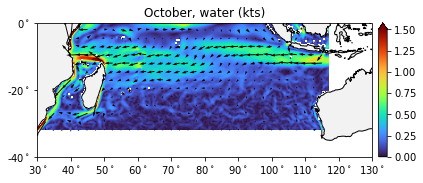

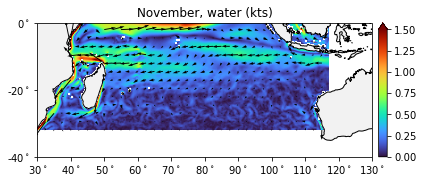

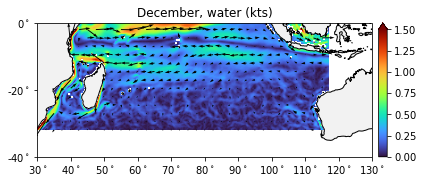

In [43]:
# plot average current speed per month
t = dswater.time.values # get time series
for nmonth in range(1,13):
    lat  = dswater.latitude.values # latitude values
    lon  = dswater.longitude.values # longitude values
    x,y  = np.meshgrid(lon,lat) # create meshgrid of longitude and latitude
    
    tidx = (t.astype('datetime64[M]').astype(int) % 12 + 1) == nmonth # get time idx of specific month
    uw   = np.mean(dswater.uo[tidx,0,:,:].values,axis=0)*tokts # longitudinal velocities
    vw   = np.mean(dswater.vo[tidx,0,:,:].values,axis=0)*tokts # lateral velocities
    z    = np.sqrt(uw**2+vw**2) # water speeds

    fig,ax = plt_base_simple(xlims,ylims,20,10) # create plot base
    im = plt_modified_imshow(x,y,z,ax,cb=True,cmap='turbo',interpolation='bilinear',vmin=0,vmax=1.5) # draw imshow
    idx = 30 # quiver step
    ax.quiver(x[::idx,::idx],y[::idx,::idx],uw[::idx,::idx],vw[::idx,::idx],units='xy',scale_units='xy',scale=0.2) # draw quiver
    ax.set(xlim=xlims,ylim=ylims,title=calendar.month_name[nmonth]+', water (kts)') # set labels
    plt.show()

C:\Users\23513098\AppData\Local\Temp\ipykernel_28556\609081773.py:10: RuntimeWarning: Mean of empty slice
  z    = np.nanmean(dswaves.VAVH_DAILY_MAX[tidx,:,:].values,axis=0) # average daily maximum wave height per month


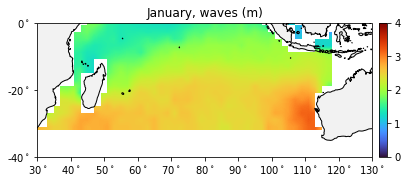

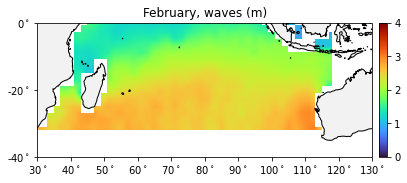

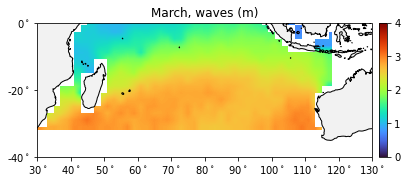

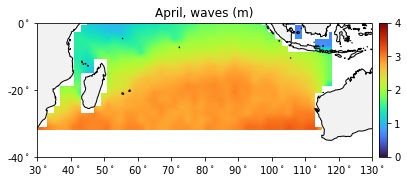

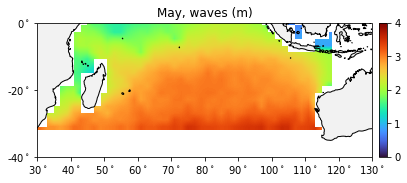

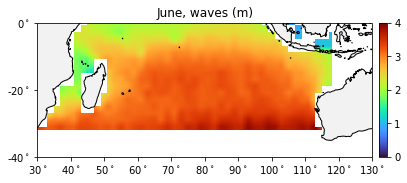

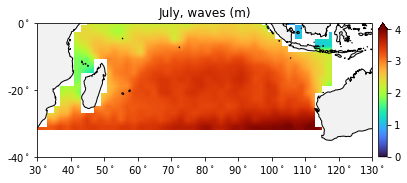

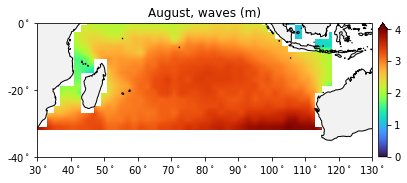

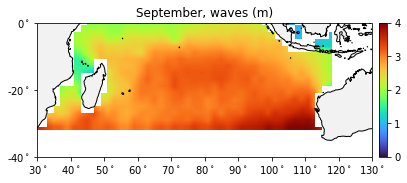

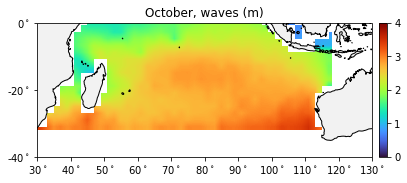

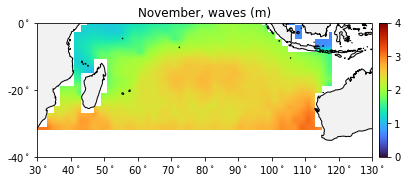

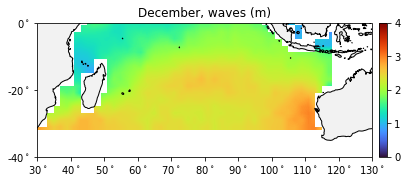

In [44]:
# plot average daily maximum wave height per month
t = dswaves.time.values # get time series

for nmonth in range(1,13):
    lat  = dswaves.latitude.values # latitude values
    lon  = dswaves.longitude.values # longitude values
    x,y  = np.meshgrid(lon,lat) # create meshgrid of longitude and latitude
    
    tidx = (t.astype('datetime64[M]').astype(int) % 12 + 1)==nmonth # get time idx of specific month
    z    = np.nanmean(dswaves.VAVH_DAILY_MAX[tidx,:,:].values,axis=0) # average daily maximum wave height per month

    fig,ax = plt_base_simple(xlims,ylims,20,10) # create plot base
    plt_modified_imshow(x,y,z,ax,cb=True,cmap='turbo',interpolation='bilinear',vmin=0,vmax=4) # draw imshow
    ax.set(xlim=xlims,ylim=ylims,title=calendar.month_name[nmonth]+', waves (m)') # set labels
    plt.show()

# 3. Body forces

This section models the forces that act on the boat. The forces that act on the boat are:

1. Rowing force, directly exerted by the rower.
1. Air drag force, induced by the relative wind (assumed to act only parallel to the direction of the boat).
1. Water drag force of the boat, induced by the relative water speed.
1. Water drag force of the anchor (if the anchor is used).

We assume that for an interval these forces are in balance. Therefore, the boat is not accelerating and thus having a constant speed. Given the duration of an interval and the boat speed, we can calculate the displacement. For a series of intervals/iterations, this results in a trajectory. 

An overview of the relation between parallel wind speed and boat speed is provided in this section. 

<span style="color:red"> Note that the used boat specifications are incorrect and should be updated.</span>

## 3.1. Functions

Functions required to calculate the total force, row speeds in optimum conditions and to plot trajectories.

In [7]:
def total_force(V,*arg): 
    '''
    Calculate sum of forces on rowing boat
    
    Parameters
    ----------
    V: boat velocity
    arg: list of arguments:
        Vw:    velocity water [longitudinal,lateral] [m/s]
        Va:    velocity air [longitudinal,lateral] [m/s]
        ed:    boat orientation [longitudinal,lateral] [-]
        Frmag: rowing force [N]
        row:   True when rowing [True/False]
        anc:   Ture when anchor is dropped[True/False]
        Gw:    friction constant of boat with water
        GwA:   friction constant of anchor with water
        Ga:    friction constant of boat with air    
    
    Returns
    -------
    Ft:        total force [longitudinal,lateral] [N]    
    '''    
    Vw,Va,ed,Frmag,row,anc,Gw,GwA,Ga = arg # fill in arguments

    # rowing force 
    Fr = int(row)*Frmag*ed

    # water friction sea anchor    
    Fwterm = np.sqrt((Vw-V).dot(Vw-V))*(Vw-V)
    Fw     = Gw*Fwterm # water friction
    Fwa    = int(anc)*GwA*Fwterm # sea anchor water friction, anchor is in when resting (row = 0)

    # air friction 
    Fa  = Ga*np.sqrt((Va-V).dot(Va-V))*(Va-V)
    Fap = Fa.dot(ed)*ed # parallel component

    # total force
    Ft  = Fw + Fwa + Fap + Fr
    return Ft

def plt_traject(fig,ax,Nhist,Xs,Xt,hide_all=False,hide_fast=False,traj_col=False): 
    '''
    Plot trajectories of optimized route
    
    Parameters
    ----------
    fig:       figure
    ax:        axis
    Nhist:     tracer data (of Nsteps iterations)
    Xs:        list of coordinates of all Nstep iterations
    Xt:        target coordinates 
    hide_all:  hide all trajectories when True
    hide_fast: hide fastest trajectory when True
    traj_col:  color trajectory by time when True     
    
    Returns
    -------
    fig,ax:    updated figure and axis
    
    '''   
    Nsteps = len(Nhist)-1 # number iterations

    if (hide_all == False): # show trajectories 
        
        if traj_col: # if trajectory should be coloured as a function of time
            cmap    = ListedColormap(plt.get_cmap('viridis',Nsteps)(np.linspace(0,1,Nsteps))) # create colormap of same length as iterations
            cax     = fig.add_axes([ax.get_position().x1+0.015,ax.get_position().y0,0.02,ax.get_position().height]) # add colorbar axis
            sm      = plt.cm.ScalarMappable(cmap=cmap,norm = mpl.colors.Normalize(vmin=0,vmax=(datet-datet0).days)) # adjust colormap
            sm.set_array([]) 
            plt.colorbar(sm,cax=cax) # plot colorbar
            
        for i in range(Nsteps): # loop over every step
            Nhisti = Nhist[Nsteps-i] # get idx of previous points
            Xs1    = Xs[Nsteps-i] # location current point
            Xs0    = Xs[Nsteps-i-1][Nhisti] # location previous point
            
            Ni     = Xs1.shape[0] # get number of points in step
            
            if traj_col == False:
                for j in range(Ni): # loop over all points
                    ax.plot([Xs0[j,0],Xs1[j,0]],[Xs0[j,1],Xs1[j,1]],color='black',linewidth=0.5) # plot line between points
            else:
                for j in range(Ni): # loop over all points
                    ax.plot([Xs0[j,0],Xs1[j,0]],[Xs0[j,1],Xs1[j,1]],color=cmap(Nsteps-i)[0:3],linewidth=1) # plot line between points

    if hide_fast == False: #show fastest trajectory
        rto  = np.array([Geodesic.WGS84.Inverse(x[1],x[0],Xt[1],Xt[0])['s12'] for x in Xs[-1]]) # distance to target 
        iwin = np.argmin(rto) # find point closest to target

        Xawin           = np.empty([Nsteps+1,2]) # allocate coordinates of this line
        Xawin[Nsteps,:] = Xs[Nsteps][iwin,:] # fill in last coordinate

        for i in range(Nsteps): # loop over all steps
            Nhisti            = Nhist[Nsteps-i] # find previous coordinate
            iwin              = Nhisti[iwin] # update idx
            Xawin[Nsteps-1-i] = Xs[Nsteps-i-1][iwin] # include coordinate

        ax.plot(Xawin[:,0],Xawin[:,1],'-',color='red',linewidth=2) # draw fastest route
    return fig,ax

def calc_vrow_wind_only(Ga,Gw,Frmag,vair):
    '''
    Calculate rowing velocity for head and tail winds (no currents and waves)
    
    Parameters
    ----------
    Ga:    air friction constant
    Gw:    water friction constant
    Frmag: rowing force magnitude from perfect conditions [N]
    vair:  parallel air speed [m/s]
    
    Returns
    -------
    vrow:  rowing velocity [m/s]
    '''
    vaireqvrow =  np.sqrt(Frmag/Gw) # no head or tail wind
    vairrow0   = -np.sqrt(Frmag/Ga) # no boat velocity
    
    # caclulate velocity per regime
    if vair > vaireqvrow: 
        vrow = (-vair*Ga+np.sqrt(Frmag*(Gw-Ga)+vair**2*Ga*Gw))/(Gw-Ga)
    elif vair == vaireqvrow:
        vrow = vaireqvrow
    elif (vair < vaireqvrow) & (vair > vairrow0):
        vrow = (vair*Ga+np.sqrt(Frmag*(Gw+Ga)-vair**2*Ga*Gw))/(Gw+Ga)
    elif vair == vairrow0:
        vrow = 0
    elif vair < vairrow0:
        vrow = (-vair*Ga-np.sqrt(Frmag*(Ga-Gw)+vair**2*Ga*Gw))/(Gw-Ga)
    return vrow

def calc_vrow_wind_only_G(G,vperf,vair):
    '''
    Same function as 'calc_vrow_wind_only', using [G,vperf] instead of [Ga,Gw,Frmag]
    
    Parameters
    ----------
    G:     ratio of air friction cosntant to water friction constant
    vperf: boat speed in perfect conditions (no wind and no waves)
    Frmag: rowing force magnitude from perfect conditions [N]
    vair:  parallel air speed [m/s]
    
    Returns
    -------
    vrow:  rowing velocity [m/s]
    '''
    # calculate the rowing velocity depending on the head and tail wind
    vaireqvrow =  np.sqrt(1+G)*vperf # no head or tail wind
    vairrow0   = -np.sqrt(1+1/G)*vperf  # no boat velocity
    
    # caclulate velocity per regime
    if vair > vaireqvrow:
        vrow = (G*vair-np.sqrt(G*vair**2-(G**2-1)*vperf**2))/(G-1)
    elif vair == vaireqvrow:
        vrow = vaireqvrow
    elif (vair < vaireqvrow) & (vair > vairrow0):
        vrow = (G*vair+np.sqrt((G+1)**2*vperf**2-G*vair**2))/(G+1)
    elif vair == vairrow0:
        vrow = 0
    elif vair < vairrow0:
        vrow = (G*vair+np.sqrt((G**2-1)*vperf**2+G*vair**2))/(G-1)
    return vrow

def plot_vrow_wind_only(G,tokts,vperf,vperf_marg): 
    '''
    Plot velocity depending on head and tail wind, for a given speed in perfect conditions (no wind and no waves)
    
    Parameters
    ----------
    G:            ratio of air friction cosntant to water friction constant
    vperf:        boat speed in perfect conditions (no wind and no waves) [m/s]
    vperf_margin: margin of vperf [m/s]
    
        
    Returns
    -------
    fig,ax:       constructed figure and axis
    '''
    tokts    = 1.94384449 # convert m/s to kts
    
    vperfmin = vperf+vperf_marg/2 # lower bound of margin vperf
    vperfmax = vperf-vperf_marg/2 # upper bound of margin vperf
       
    Ngrid    = 1000 # number of air velocities
    vairr    = np.linspace(-30,30,Ngrid)/tokts # grid of air velocities
    
    # allocate
    vrowairr    = np.empty(Ngrid) # boat speed at vperf
    vrowairrN   = np.empty(Ngrid) # boat speed at vperf (numerical value calculated from 'total_force()')
    vrowairrmin = np.empty(Ngrid) # boat speed at lower bound vperf
    vrowairrmax = np.empty(Ngrid) # boat speed at upper bound vperf
    
    vaireqvrow =  np.sqrt(1+G)*vperf # no head or tail wind
    vairrow0   = -np.sqrt(1+1/G)*vperf  # no boat velocity
    
    for i in range(Ngrid): # loop over all grid points 
        # calculate boat speeds
        vrowairr[i]    = calc_vrow_wind_only_G(G,vperf,vairr[i])
        vrowairrmin[i] = calc_vrow_wind_only_G(G,vperfmin,vairr[i])
        vrowairrmax[i] = calc_vrow_wind_only_G(G,vperfmax,vairr[i])        
        vrowairrN[i]   = fsolve(total_force,list((vperf+vairr[i]*0.1)*np.array([1,0])),args=(np.array([0,0]),np.array([vairr[i],0]),np.array([1,0]),Frmag,True,False,Gw,GwA,Ga))[0]

    %matplotlib inline
    fig, ax = plt.subplots(figsize=(4,4*14.25/11.45)) # create figure
     
    ax.axhline(y=0, color='black', linestyle='-',linewidth=0.5) # add line at y=0
    
    # draw lines and areas of boat speeds
    ax.fill_between(np.abs(vairr[vairr<=0])*tokts, vrowairrmin[vairr<=0]*tokts,vrowairrmax[vairr<=0]*tokts,color='orange', alpha=0.5)
    ax.fill_between(np.abs(vairr[vairr>=0])*tokts, vrowairrmin[vairr>=0]*tokts,vrowairrmax[vairr>=0]*tokts,color='yellow', alpha=0.5)
    ax.plot(np.abs(vairr*tokts),vrowairrmin*tokts,color='black',linewidth=0.5)
    ax.plot(np.abs(vairr*tokts),vrowairrmax*tokts,color='black',linewidth=0.5)
    ax.plot(np.abs(vairr*tokts),vrowairr   *tokts,color='black',linewidth=0.5)
    ax.plot(np.abs(vairr*tokts),vrowairrN  *tokts,':',color='red',linewidth=2)
    
    ax.set(xlim=[0,np.max(np.abs(vairr))*tokts],ylim=[-3,5],title='$G = {:.4f}$'.format(G),xlabel='Wind speed (kts)',ylabel='Rowing speed (kts)') # add labels
    return fig,ax

## 3.2. Analysis
List the parameters related to the forces acting on the boat. In addition, provide an overview of the boat speed as a function of the parallel wind component. 

Ratio Ga/Gw  = 0.0400
Rowing force = 42.28 N
Rowing power = 43.50 W
Velocity (0 Kts, no waves and currents)   = 2.00 Kts
Velocity (+25 Kts, no waves and currents) = 4.57 Kts
Velocity (-25 Kts, no waves and currents) = -3.73 Kts


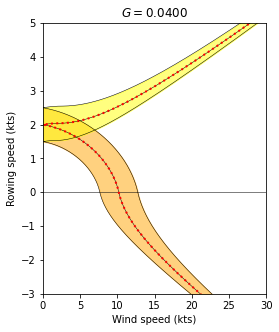

In [8]:
# boat specifications
m     = 670 # wiegth [kg]

# water friction - boat
rhow  = 1024 # density water [kg/m^3]
Aw    = 15 # frontal area exposed to water
Cdw   = 0.005 # friction coef. water 
Gw    = rhow*Cdw*Aw/2 # water friction constant

# water friction - anchor
GwA   = 50*Gw # water friction constant sea anchor

# air friction 
rhoa  = 1.225 # density air [kg/m^3]
Aa    = 2 # frontal area exposed to air
Cda   = 0.04*Gw/(0.5*rhoa*Aa) # friction coef. air 
Ga    = rhoa*Cda*Aa/2 # air friction constant

# friction ratio boat
G     = Ga/Gw # ratio of air friction cosntant to water friction constant

# calculate force from velocity in perfect conditions
vperf = 2/tokts # boat velocity in perfect conditions [m/s]
Frmag = (Ga+Gw)*vperf**2 # calculate rowing force magnitude from perfect conditions [N]
Pr    = Frmag*vperf # rowing power [W]

# provide overview of velocity and friction
print("Ratio Ga/Gw  = {:.4f}".format(G))
print("Rowing force = {:.2f} N".format(Frmag))
print("Rowing power = {:.2f} W".format(Pr))
print("Velocity (0 Kts, no waves and currents)   = {:.2f} Kts".format(vperf*tokts))
print("Velocity (+25 Kts, no waves and currents) = {:.2f} Kts".format(calc_vrow_wind_only(Ga,Gw,Frmag,+25/tokts)*tokts))
print("Velocity (-25 Kts, no waves and currents) = {:.2f} Kts".format(calc_vrow_wind_only(Ga,Gw,Frmag,-25/tokts)*tokts))

fig,ax = plot_vrow_wind_only(G,tokts,vperf,1/tokts)

# 4. Interval activity
We divide the day up into intervals of different activity. This activity would be either rowing or resting. As an example: start the day by taking a rest till 8:00, row till 12:00 rest till 14:00, row till 18:00 and continue taking a rest. Note that we assume the pattern of rowing activity is the same for every day.

## 4.1 Functions 
Divide the day into intervals given the time when to start and stop rowing.

In [9]:
def interval_activity(tod_start,tod_stop):
    '''
    Construct intervals indicating rowing activity 
    
    Parameters
    ----------
    tod_start: list of timestamps to start rowing
    tod_stop:  list of timestamps to stop rowing
        
    Returns
    -------
    int0:   interval starting times [s of day]
    introw: indicate per interval whether rowing (True) or not rowing (False) [True/False]
    intdur: duration per interval [s]
    intN:   total number of intervals per day
    '''
        
    # split day into intervals
    int0row   = np.array(pd.to_timedelta(tod_start).total_seconds()).astype(int) # start rowing [s]
    int0rest  = np.array(pd.to_timedelta(tod_stop).total_seconds()).astype(int) # start resting [s]
    int0      = np.append(int0row,int0rest) # interval starting times (both rowing and resting) [s]
    introw    = np.append(np.ones(int0row.shape).astype(bool),np.zeros(int0rest.shape).astype(bool)) # activity (True = rowing, False = resting)

    order     = np.argsort(int0) # sort intervals in time
    int0      = int0[order] # sort starting times [s]
    introw    = introw[order] # sort activity [bool]
    intdur    = np.diff(np.append(int0,24*3600+int0[0])) # calculate interval duration [s]
    intN      = len(int0) # total number of intervals per day
    return int0,introw,intdur,intN

def interval0(datet0,int0): 
    '''
    Calculate idx and duration of starting interval
    
    Parameters
    ----------
    datet0: starting timestamp [datetime]
    int0:   interval starting times [s of day]
        
    Returns
    -------
    k0:     interval index
    dt0:    timestep till next interval
    '''  
    intdur = np.diff(np.append(int0,24*3600+int0[0])) # calculate interval duration [s]
    intN   = len(int0) # total number of intervals per day
    t0     = int((datet0-pd.to_datetime(datet0.date())).total_seconds()) # starting time [second of day]
    if t0<int0[0]: # if in interval that started the day before and runs in the next day
        k0  = intN-1 # interval index
        dt0 = int0[0]-t0 # timestep till next interval
    else:
        k0  = np.where(int0<=t0)[0][-1] # interval index
        dt0 = intdur[k0]-(t0-int0[k0]) # timestep till next interval
        
    return k0,dt0

## Analysis
Show an overview of the the rowing activity as a function of time for a single day.

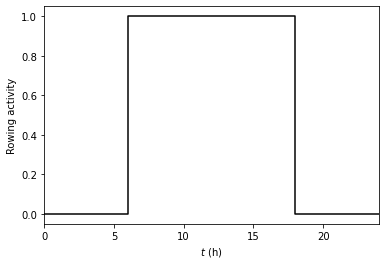

In [11]:
tod_start = ['06:00:00'] # start rowing - time of day
tod_stop  = ['18:00:00'] # stop rowing - time of day
   
int0,introw,intdur,intN = interval_activity(tod_start,tod_stop) # Construct intervals indicating rowing activity 

# plot rowing activity as function of time of day
fig,ax = plt.subplots()
plt.step(np.append(np.append(0,int0),3600*24)/(3600),np.append(np.append(introw[-1],introw),introw[-1]),where='post',color='black')
ax.set_xlim([0,24])
ax.set_ylabel('Rowing activity')
ax.set_xlabel('$t$ (h)')
plt.show()
plt.close()

# 6. Single route rowing model

A single row is simulated in this section. This model is used to illustrate a series of iterations to propel the rower forwards.  A single iteration has the duration of an activity interval (see previous section). For every interval, the air and water velocities are pulled from the hindcast data.

This model is based on a single rule (i.e. always rowing towards the destination). Therefore, the route resulting from this single route model might not results in the optimum route. The optimized model is discussed in the next section.

## 6.1. Functions
This section includes the required functions to extract the hindcast data for the given date, time and location. First, the specific data and time of the hindcast is selected, resulting in a 2D hindcast field. Subsequently, the hindcast at the location of the rower is extracted.

This section also includes the functions required to plot the iterations of the model and to calculate the angle between two points in space.

In [13]:
def hindcast_slice_data(datet,dswind,dswater):  
    '''
    Load in hindcast data (water and air speeds) at a specific date and time
    
    Parameters
    ----------
    datet:   timestamp in datetime
    dswind:  dataset of wind speeds
    dswater: dataset of water speeds
        
    Returns
    -------
    Dua:     longitudinal air velocity on grid
    Dva:     lateral air velocity on grid
    Duw:     longitudinal water velocity on grid
    Dvw:     lateral water velocity on grid
    '''  
    
    # air speeds dataset
    Dadatet    = dswind.time.values # timeseries air
    Dadatetidx = np.argmin(np.abs(Dadatet-datet.to_datetime64())) # find nearest timestamp in dataset

    Dua = dswind.northward_wind[Dadatetidx,0,:,:].values # longitudinal air velocity on grid
    Dva = dswind.eastward_wind [Dadatetidx,0,:,:].values # lateral air velocity on grid

    # water speeds dataset
    Dwdatet    = dswater.time.values # time series water
    Dwdatetidx = np.argmin(np.abs(Dwdatet-datet.to_datetime64())) # find nearest timestamp in dataset

    Duw = dswater.uo[Dwdatetidx,0,:,:].values # longitudinal water velocity on grid
    Dvw = dswater.vo[Dwdatetidx,0,:,:].values # lateral water velocity on grid
    
    return Dua,Dva,Duw,Dvw

def hindcast_get_vel(Dua,Dva,Duw,Dvw,X,Dalat,Dalon,Dwlat,Dwlon):    
    '''
    Get water and air velocities near boat from hindcast
    
    Parameters
    ----------
    Dua:   longitudinal air velocity on grid
    Dva:   lateral air velocity on grid
    Duw:   longitudinal water velocity on grid
    Dvw:   lateral water velocity on grid
    X:     boat location [degrees]
    Dalat: latitude coordinate from dataset air
    Dalon: longitude coordinate from dataset air
    Dwlat: latitude coordinate from dataset water
    Dwlon: longitude coordinate from dataset water
        
    Returns
    -------
    Va:    air velocity [longitudinal,lateral]
    Vw:    water velocity [longitudinal,lateral]
    '''  
    
    # air velocity
    Dalatidx = np.argmin(np.abs(Dalat-X[1])) # find nearest latitude in dataset
    Dalonidx = np.argmin(np.abs(Dalon-X[0])) # find nearest longitude in dataset

    ua = Dua[Dalatidx,Dalonidx] # get latitudinal velocity
    va = Dva[Dalatidx,Dalonidx] # get longitudinal velocity
    Va = np.array([ua,va]) # write velocities into 2D array

    if np.any(np.isnan(Va)): # if no data available 
        Va = np.array([0,0]) # set velocity equal to zero

    # water velocity
    Dwlatidx = np.argmin(np.abs(Dwlat-X[1])) # find nearest latitude in dataset
    Dwlonidx = np.argmin(np.abs(Dwlon-X[0])) # find nearest longitude in dataset

    uw = Duw[Dwlatidx,Dwlonidx] # get latitudinal velocity
    vw = Dvw[Dwlatidx,Dwlonidx] # get longitudinal velocity
    Vw = np.array([uw,vw]) # write velocities into 2D array

    if np.any(np.isnan(Vw)): # if no data available 
        Vw = np.array([0,0]) # set velocity equal to zero
        
    return Va,Vw

def plt_base_iteration(X0,Xt,xlims,ylims,ytickspacing,xtickspacing,title=' '): 
    '''
    Create base of plot suited for model iterations
    
    Parameters
    ----------
    X0:                        starting location [deg]
    Xt:                        destiation location [deg]
    xlims,ylims:               ax limits [deg]
    ytickspacing,xtickspacing: tick spacing [deg]
    title:                     title of plot
    
    Returns
    -------
    fig,ax:                    plot base
    '''         
    fig,ax = plt_base_simple(xlims,ylims,ytickspacing,xtickspacing) # create base of plot
    ax.set(**{'title':title}) # add title

    ax.scatter(X0[0],X0[1] ,50,color='blue') # add starting location 
    ax.scatter(Xt[0],Xt[1] ,50,color='red') # add destination location
    plon,plat = line_cords(X0[1],X0[0],Xt[1],Xt[0],N=100) # calculate geodesic distance 
    plt.plot(plon,plat,'--',color='grey',zorder=0) # plot geodesic distance 
    fig.canvas.draw() # draw canvas
    return fig,ax

def angle_between(p1, p2):
    '''
    Calculate angle between two points
    
    Parameters
    ----------
    p1:    point 1 [x,y]
    p2:    point 2 [x,y]
    
    Returns
    -------
    angle: anlge between points
    '''    
    ang1 = np.arctan2(*p1[::-1]) # take arctan of first point
    ang2 = np.arctan2(*p2[::-1]) # take arctan of second point
    angle = np.rad2deg((ang1 - ang2) % (2 * np.pi)) # calculate angle between points
    
    return angle

## 6.2 Model analysis
This section models the route of a rower given a single rule (i.e. always row towards the destination). The model takes into account the following: starting location and time, target locations, activity intervals, rowing force. For every iteration, the boat velocity and hindcast is stored.

Note that this model is designed in such a way that it can be extended to a model that finds the optimum route, as will be discussed in the next section.

<IPython.core.display.Javascript object>


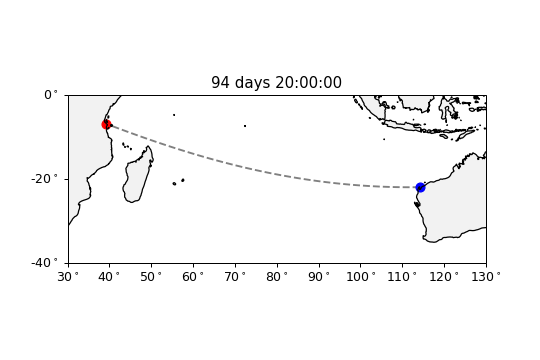

In [170]:
# model configuration
start_loc = 'Exmouth' # starting location
end_loc   = 'Dar es Salaam' # target location

vperf = 2/tokts # boat velocity in perfect conditions [m/s]

datet0    = pd.Timestamp('2018-04-01 00:00:00') # starting datetime
tod_start = ['06:00:00','14:00:00'] # start rowing - time of day
tod_stop  = ['12:00:00','20:00:00'] # stop rowing - time of day

imax = 1000 # maximum number of iterations

phir = np.array([0]) # angle offsets to target

# intialize model
# calculate force from velocity in perfect conditions
Frmag = (Ga+Gw)*vperf**2 # calculate rowing force magnitude from perfect conditions [N]
Pr    = Frmag*vperf # rowing power [W]
int0,introw,intdur,intN = interval_activity(tod_start,tod_stop) # row activity

# start location
lon0   = dfSloc[dfSloc.start_loc==start_loc].lon.item()
lat0   = dfSloc[dfSloc.start_loc==start_loc].lat.item()
X0     = np.array([lon0,lat0])

# target
latt   = dfEloc[dfEloc.end_loc==end_loc].lat.item()
lont   = dfEloc[dfEloc.end_loc==end_loc].lon.item()
Xt     = np.array([lont,latt])
rt0    = Geodesic.WGS84.Inverse(X0[1],X0[0],Xt[1],Xt[0])['s12'] # distance to target
rtmin  = np.max([np.max(intdur[introw])*vperf*1.5,100000]) # threshold of distance till target [m]

# store values during iterations
jstep  = 1 # store values after every jstep
datets = np.empty([int(np.ceil(imax/jstep))]) # allocate to store time
datets.fill(np.nan) 
 
# intialize 
N       = 1; # number of starting points
Nr      = np.arange(0,N).astype(int) # make range of starting points
Xa      = np.empty([N,2]) # allocate all locations
Xa[0,:] = X0 # location 
i       = 0 # iteration
j       = 0 # storage iteration
k,dt    = interval0(datet0,int0) # k: idx interval, dt: timestep interval
rto     = np.array([Geodesic.WGS84.Inverse(x[1],x[0],Xt[1],Xt[0])['s12'] for x in Xa]) # geodesic distance to target
datet   = datet0 # datetime series

# rowing directions 
Nphir   = len(phir) # number of angle offsets

# dataset coordinates
Dalat   = dswind.latitude.values
Dalon   = dswind.longitude.values
Dwlat   = dswater.latitude.values
Dwlon   = dswater.longitude.values
Dadatet = dswind.time.values

# load hindcast data 
Dua,Dva,Duw,Dvw = hindcast_slice_data(datet,dswind,dswater) # get slice of hindcast air and water velocities
Va,Vw = hindcast_get_vel(Dua,Dva,Duw,Dvw,X0,Dalat,Dalon,Dwlat,Dwlon) # get air and water velocities at location of boat

# store variables
Xs     = []; Xs.append(Xa)
Vas    = []; Vas.append(np.array([Va]))
Vws    = []; Vws.append(np.array([Vw]))
Vs     = []; Vs.append(np.array([[np.nan,np.nan]]))
datets = []; datets.append(datet.to_numpy())
Nhist  = []; Nhist.append(None)

# create plot
%matplotlib notebook
fig,ax = plt_base_iteration(X0,Xt,[30,130],[-40,0],20,10,title = pd.to_timedelta(np.round((datet-datet0).total_seconds()),'s'))
pltraj = ax.plot(Xa[:,0],Xa[:,1],'o',color='black',markersize=1.5)

while (i < (imax-1)) & np.all(rto > rtmin): # start loop
    i = i+1  # next iteration
    
    # rowing activity
    rowt = introw[k] # check rowing activity options
    if rowt == True: # if rowing
        No   = 1 # only row
        phio = np.array([phir]) # rowing direction options
        rowo = np.array([True]) # rowing options
        anco = np.array([False]) # anchor options
    if rowt == False: # if resting
        No   = 1 # only anchor
        phio = np.array([np.nan]) # rowing direction options
        rowo = np.array([False]) # rowing options
        anco = np.array([True]) # anchor options
    
    # allocate all new locations and velocities per time step
    Xaold  = Xa 
    Xa     = np.empty([N*No,2])
    Vai    = np.empty([N*No,2])
    Vwi    = np.empty([N*No,2])
    Vi     = np.empty([N*No,2])
    Nhisti = np.zeros([N*No]).astype(int)
    
    # load hindcast data 
    Dua,Dva,Duw,Dvw = hindcast_slice_data(datet,dswind,dswater) # get slice of hindcast air and water velocities
    
    for ii in range(N): # loop over every starting location  
        X = np.copy(Xaold[ii,:]) # get starting location
        
        # air and water velocity
        Va,Vw = hindcast_get_vel(Dua,Dva,Duw,Dvw,X,Dalat,Dalon,Dwlat,Dwlon) # get air and water velocities at location of boat
        
        for jj in range(No): # loop over every activity option
           
            Nhisti[ii*No+jj] = Nr[ii] # get starting point idx
            
            # get option details
            phi = phio[jj] 
            row = rowo[jj]
            anc = anco[jj]
        
            # direction
            if row: # when rowing
                theta  = Geodesic.WGS84.Inverse(X[1],X[0],Xt[1],Xt[0])['azi1'] # row in direction of destination (bearing geodesic)
                theta += phi # deviate from direction
                ed     = (np.array([np.sin(theta/180*np.pi),np.cos(theta/180*np.pi)])).flatten()
            else: # when resting 
                if Va.dot(Va)!=0: # if there is wind
                    ed    = (Va/np.sqrt(Va.dot(Va))).flatten() # boat turns in direction of wind
                else: # if there is no wind
                    theta = Geodesic.WGS84.Inverse(X[1],X[0],Xt[1],Xt[0])['azi1'] # in direction of destination (bearing geodesic)
                    ed    = (np.array([np.sin(theta/180*np.pi),np.cos(theta/180*np.pi)])).flatten()

            # calculate boat velocity
            V = fsolve(total_force,list(ed*(vperf*int(row)+Vw*0.2+Va*0.1)),args=(Vw,Va,ed,Frmag,row,anc,Gw,GwA,Ga),xtol=1e-04)

            # update velocity and position
            vmag = np.sqrt(V[0]**2+V[1]**2)
            if vmag != 0: # only update X if there is a V
                azi1 = angle_between([0,1],V)
                s12  = vmag*dt
                Xnew = np.array(list(map(Geodesic.WGS84.Direct(X[1],X[0],azi1,s12).get, ['lon2','lat2']))) # new location
            else:
                Xnew = np.copy(X)
                
            # get distances from start and end
            r0 = Geodesic.WGS84.Inverse(Xnew[1],Xnew[0],X0[1],X0[0])['s12'] # distance to starting point
            rt = Geodesic.WGS84.Inverse(Xnew[1],Xnew[0],Xt[1],Xt[0])['s12'] # distance to target point
      
            if np.logical_not(Point([Xnew[0],Xnew[1]]).intersects(pdom)) & (r0 > rtmin) & (rt > rtmin): #if on land
                Xnew  = np.array([np.nan,np.nan])
            else: # if in allowed region
                Xnew  = Xnew    
                
            # store values
            Xa [ii*No+jj,:] = Xnew 
            Vai[ii*No+jj,:] = Va
            Vwi[ii*No+jj,:] = Vw
            Vi [ii*No+jj,:] = V
       
    # distance to target
    rto = np.array([Geodesic.WGS84.Inverse(x[1],x[0],Xt[1],Xt[0])['s12'] for x in Xa])# geodesic distance to target
    N   = Xa.shape[0]
    Nr  = np.arange(0,N)
    
    # update datet
    datet = datet+pd.to_timedelta(dt,'s')   

    # store values
    Xs   .append(Xa)
    Nhist.append(Nhisti)
    Vas  .append(Vai)
    Vws  .append(Vwi)
    Vs   .append(Vi)
    datets.append(datet.to_numpy())
    
    # for next step
    k  = (k+1)%intN
    dt = intdur[k]
    
    print('Iteration: '+str(round(i/imax*1000)/10)+'%, Distance: '+str(round((1-np.min(rto)/rt0)*1000)/10)+'%', end='\r')

    if i%5 == 0: # plot locations
        pltrajpop = pltraj.pop(0)
        pltrajpop.remove()
        pltraj    = ax.plot(Xa[:,0],Xa[:,1],'o',color='black',markersize=1.5)
        fig.canvas.draw()
        ax.set_title(pd.to_timedelta(np.round((datet-datet0).total_seconds()),'s'))
plt.show()

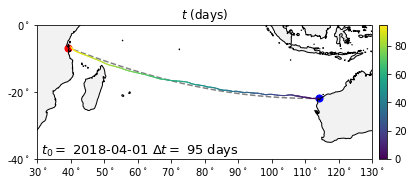

In [168]:
# plot trajectories as function of time
%matplotlib inline
titlem = '$t_0 = $ '+datet0.strftime('%Y-%m-%d')+' $\Delta t = $ '+str((datet-datet0).days)+' days'
fig,ax = plt_base_iteration(X0,Xt,xlims,ylims,20,10,title = '$t$ (days)')
fig,ax = plt_traject(fig,ax,Nhist,Xs,Xt,hide_all = False, hide_fast = True, traj_col = True)
ax.annotate(titlem, xy=(0.01, 0),xycoords='axes fraction', fontsize=13, horizontalalignment='left', verticalalignment='bottom')
plt.show()

# 7. Optimized rowing model
In this section, an optimized rowing model is constructed. The model works similarly to the single route model of the previous section. In this case, the optimized route is defined as the fastest route. To find the optimum route, all possible rowing directions and activities (rowing or resting with/without anchor) should be considered. Numerically, this would become computationally expensive. Instead, we only consider a selection of rowing directions at a fixed speed. 

The model is constructed as follows: starting from a single location the rower can either (1) row, (2.1) rest without an anchor or (2.2) rest with an anchor. When rowing, we assume the rower rows for the entire duration of the activity interval (i.e. 4 hours) at a fixed speed. Note that we consider multiple options of rowing directions. The most straightforward option would be to row in the direction of the destination. However, another option would be to row 10 degrees clockwise with respect to the destination, or 20 degrees clockwise, etc. In total, the number of options for the rower from a single starting location equals: N (number of rowing directions) + 1 (resting without anchor) + 1 (resting with an anchor). When the rower is not allowed to row (e.g. forced resting), then the number of options reduces to 2: 1 (resting without anchor) + 1 (resting with an anchor).

Each option from the same starting point results in a different ending point. In the next iteration, these ending points can be used as individual starting points, resulting in even more new ending points. This will create a snowflake show, which keeps growing for an increasing number of iterations. The first point that reaches the final destination belongs to the branch of options that results in the fastest route. 

Note that every starting point generates even more ending points, causing an exponential increase of computational power for increasing iterations. This tells us that the number of ending points should be filtered (e.g. make a selection of ending locations). For example, an ending point that is moving away from the final destination could be excluded in the next iteration. In this model, we use a circular filter centred around the final destination. This filter draws a number of circle segments around the final destination. There will be segments with no points (e.g. boat locations of iteration) in it, segments with a single point and segments with multiple points. For every segment, we only keep the point that is closest to the final destination. In this way, we filter based on the distance to the final destination but also filter based on the spacing between the points. 

## 7.1. Functions
This section contains the circular filter to reduce the number of points (e.g. boat locations of iteration).

In [ ]:
def filter_circular(Xa,Xt,Np,keepsides=True,geo=False):
    '''
    Filter points close to target (bin by anlge with target)
    
    Parameters
    ----------
    Xa:        boat coordinates
    Xt:        target coordinate
    Np:        number of remaining locations after filtering
    keepsides: most outer locations are kept in addition when True
    geo:       True when applied to coordinates (in degree), False when applied to locations (in m) 
        
    Returns
    -------
    Xaf:       filtered locations
    idxkeep:   indexes of Xa that remain (not removed by the filtration)
    '''    
    NXa = Xa.shape[0] # number of points
    if NXa>Np: # apply this function if there are more points then requested segments
        Xa0 = Xa-Xt # set Xt as centre point (0,0)     
        if geo: # when applied to coordinates
            dis = np.array([Geodesic.WGS84.Inverse(x[1],x[0],Xt[1],Xt[0])['s12'] for x in Xa]) # calculate distance to target    
            phi = np.array([Geodesic.WGS84.Inverse(Xt[1],Xt[0],x[1],x[0])['azi1']/180*np.pi for x in Xa]) # calculate angle from target to boat
        else: # when applied to locations 
            dis = np.sqrt(Xa0[:,0]**2+Xa0[:,1]**2) # calculate distance to target 
            phi = np.arctan2(Xa0[:,1],Xa0[:,0])+np.pi # calculate angle from target to boat
        
        # find outer locations by finding the interval using the largest difference between angles 
        phis    = np.sort(phi) # sort angles
        phis2   = np.append(phis,phis+2*np.pi) # add angles 2pi displaced 
        idxmdif = np.argmax(np.diff(phis2)[:NXa]) # find idx of largest angle 

        # define interval
        if idxmdif == NXa-1: # when idx of largest angle is the last sorted location
            # interval boundaries
            phimin  = phis[0] # start of interval
            phimax  = phis[idxmdif] # end of interval

            # normalize interval by setting phimin to zero
            phinmin = 0 # normalized start of interval
            phinmax = phimax-phimin # normalized end of interval
        else: # when idx of largest angle is in between the sorted locations
            # interval boundaries
            phimin  = phis[idxmdif+1] # start of interval
            phimax  = phis[idxmdif] # end of interval

            # normalize interval by setting phimin to zero
            phinmin = 0 # normalized start of interval
            phinmax = 2*np.pi-(phimin-phimax) # normalized end of interval
            
        # normalize all angles
        phin                = phi-phimin # normalize all angles
        phin[phin<0]       += 2*np.pi # updated to boundaries
        phin[phin>2*np.pi] -= 2*np.pi # updated to boundaries

        Nseg  = Np # number of segments
        Nsegd = 0 # allocate number of filled segments (should equal Np)
                   
        while Nsegd < Np: # when there are less filled segments than requested number of locations
            binedge            = np.linspace(0,phinmax,Nseg+1) # bin segments

            inds = np.digitize(phin,binedge)-1 # check if locoations in segments
            inds[inds>(Nseg-1)] = Nseg-1 # include angle at phimax in last segment

            indsunq = np.unique(inds) # find unique segments
            Nsegd   = len(indsunq) # total number of filled segments
            
            if Nsegd < Np: # if there are less filled segments (which meanch less remainging locations) than requested locations
                Nseg += 1 # increase number of segments
                
        idxkeep = np.zeros(NXa).astype(bool) # allocate array to indicate if location should be kept (= True) or removed (= False)

        for i in range(Nsegd): # loop over all segments
            idx    = inds == indsunq[i] # get indexes of segment
            Xa0i   = Xa0[idx,:] # coordinates of locations in segment
            disi   = dis[idx] # distances of locations in segment
            idxmin = np.argmin(disi) # find which location is closest to target
            idxkeep[np.where(idx)[0][idxmin]] = True # keep closest location
        if keepsides: # when keepsides is requested
            idxkeep[np.argmax(phin)] = True # keep minumum anlge
            idxkeep[np.argmin(phin)] = True # keep maximum angle

        Xa0b = Xa0[idxkeep] # filter locations
        Xaf  = Xa0b+Xt # transfer locations (with respect to target) back to original locations 
    else: # if there are less available points then requested segments, then no filtering is required
        Xaf = Xa # keep all locations
        idxkeep = np.ones(NXa).astype(bool) # note all indexes as kept
    return Xaf,idxkeep

## 7.2 Model analysis
Compile optimized model and show overview plots.

<IPython.core.display.Javascript object>


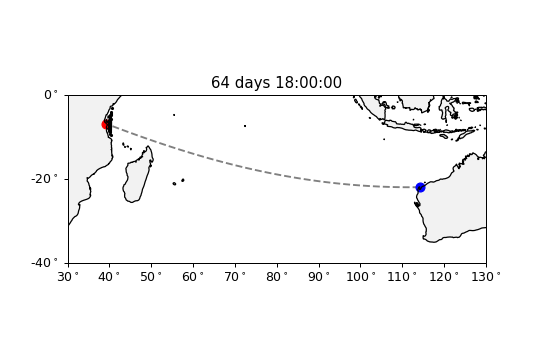

In [171]:
# model configuration
start_loc = 'Exmouth' # starting location
end_loc   = 'Dar es Salaam' # target location

vperf = 2/tokts # boat velocity in perfect conditions [m/s]

datet0    = pd.Timestamp('2018-04-01 00:00:00') # starting datetime
tod_start = ['06:00:00'] # start rowing - time of day
tod_stop  = ['18:00:00'] # stop rowing - time of day

imax = 1000 # maximum number of iterations

phir = np.linspace(-90,90,9) # angle offsets to target

# intialize model
# calculate force from velocity in perfect conditions
Frmag = (Ga+Gw)*vperf**2 # calculate rowing force magnitude from perfect conditions [N]
Pr    = Frmag*vperf # rowing power [W]
int0,introw,intdur,intN = interval_activity(tod_start,tod_stop) # row activity

# start location
lon0   = dfSloc[dfSloc.start_loc==start_loc].lon.item()
lat0   = dfSloc[dfSloc.start_loc==start_loc].lat.item()
X0     = np.array([lon0,lat0])

# target
latt   = dfEloc[dfEloc.end_loc==end_loc].lat.item()
lont   = dfEloc[dfEloc.end_loc==end_loc].lon.item()
Xt     = np.array([lont,latt])
rt0    = Geodesic.WGS84.Inverse(X0[1],X0[0],Xt[1],Xt[0])['s12'] # distance to target
rtmin  = np.max([np.max(intdur[introw])*vperf*1.5,50000]) # threshold of distance till target [m]

# store values during iterations
jstep  = 1 # store values after every jstep
datets = np.empty([int(np.ceil(imax/jstep))]) # allocate to store time
datets.fill(np.nan) 
 
# intialize 
N       = 1; # number of starting points
Nr      = np.arange(0,N).astype(int) # make range of starting points
Xa      = np.empty([N,2]) # allocate all locations
Xa[0,:] = X0 # location 
i       = 0 # iteration
j       = 0 # storage iteration
k,dt    = interval0(datet0,int0) # k: idx interval, dt: timestep interval
rto     = np.array([Geodesic.WGS84.Inverse(x[1],x[0],Xt[1],Xt[0])['s12'] for x in Xa]) # geodesic distance to target
datet   = datet0 # datetime series

# rowing directions 
Nphir   = len(phir) # number of angle offsets

# dataset coordinates
Dalat   = dswind.latitude.values
Dalon   = dswind.longitude.values
Dwlat   = dswater.latitude.values
Dwlon   = dswater.longitude.values
Dadatet = dswind.time.values

# load hindcast data 
Dua,Dva,Duw,Dvw = hindcast_slice_data(datet,dswind,dswater) # get slice of hindcast air and water velocities
Va,Vw = hindcast_get_vel(Dua,Dva,Duw,Dvw,X0,Dalat,Dalon,Dwlat,Dwlon) # get air and water velocities at location of boat

# store variables
Xs     = []; Xs.append(Xa)
Vas    = []; Vas.append(np.array([Va]))
Vws    = []; Vws.append(np.array([Vw]))
Vs     = []; Vs.append(np.array([[np.nan,np.nan]]))
datets = []; datets.append(datet.to_numpy())
Nhist  = []; Nhist.append(None)

# create plot
%matplotlib notebook
fig,ax = plt_base_iteration(X0,Xt,[30,130],[-40,0],20,10,title = pd.to_timedelta(np.round((datet-datet0).total_seconds()),'s'))
pltraj = ax.plot(Xa[:,0],Xa[:,1],'o',color='black',markersize=1.5)

while (i < (imax-1)) & np.all(rto > rtmin): # start loop
    i = i+1  # next iteration
    
    # rowing activity
    rowt = introw[k] # check rowing activity options
    if rowt == True: # if rowing
        No   = Nphir+2 # can row (Nphir options) or rest(2 options: with and without anchor)
        phio = np.append(phir,[np.nan,np.nan]) # rowing direction options
        rowo = np.append(np.tile(True,Nphir),[False,False]) # rowing options
        anco = np.append(np.tile(False,Nphir),[False,True]) # anchor options
    if rowt == False: # if resting
        No   = 2 # 2 options: with and without anchor
        phio = np.array([np.nan,np.nan]) # rowing direction options
        rowo = np.array([False,False]) # rowing options
        anco = np.array([False,True]) # anchor options
    
    # allocate all new locations and velocities per time step
    Xaold  = Xa 
    Xa     = np.empty([N*No,2])
    Vai    = np.empty([N*No,2])
    Vwi    = np.empty([N*No,2])
    Vi     = np.empty([N*No,2])
    Nhisti = np.zeros([N*No]).astype(int)
    
    # load hindcast data 
    Dua,Dva,Duw,Dvw = hindcast_slice_data(datet,dswind,dswater) # get slice of hindcast air and water velocities
    
    for ii in range(N): # loop over every starting location  
        X = np.copy(Xaold[ii,:]) # get starting location
        
        # air and water velocity
        Va,Vw = hindcast_get_vel(Dua,Dva,Duw,Dvw,X,Dalat,Dalon,Dwlat,Dwlon) # get air and water velocities at location of boat
        
        for jj in range(No): # loop over every activity option
           
            Nhisti[ii*No+jj] = Nr[ii] # get starting point idx
            
            # get option details
            phi = phio[jj] 
            row = rowo[jj]
            anc = anco[jj]
        
            # direction
            if row: # when rowing
                theta  = Geodesic.WGS84.Inverse(X[1],X[0],Xt[1],Xt[0])['azi1'] # row in direction of destination (bearing geodesic)
                theta += phi # deviate from direction
                ed     = np.array([np.sin(theta/180*np.pi),np.cos(theta/180*np.pi)])
            else: # when resting 
                if Va.dot(Va)!=0: # if there is wind
                    ed    = Va/np.sqrt(Va.dot(Va)) # boat turns in direction of wind
                else: # if there is no wind
                    theta = Geodesic.WGS84.Inverse(X[1],X[0],Xt[1],Xt[0])['azi1'] # in direction of destination (bearing geodesic)
                    ed    = np.array([np.sin(theta/180*np.pi),np.cos(theta/180*np.pi)])

            # calculate boat velocity
            V = fsolve(total_force,list(ed*(vperf*int(row)+Vw*0.2+Va*0.1)),args=(Vw,Va,ed,Frmag,row,anc,Gw,GwA,Ga),xtol=1e-04)

            # update velocity and position
            vmag = np.sqrt(V[0]**2+V[1]**2)
            if vmag != 0: # only update X if there is a V
                azi1 = angle_between([0,1],V)
                s12  = vmag*dt
                Xnew = np.array(list(map(Geodesic.WGS84.Direct(X[1],X[0],azi1,s12).get, ['lon2','lat2']))) # new location
            else:
                Xnew = np.copy(X)
                
            # get distances from start and end
            r0 = Geodesic.WGS84.Inverse(Xnew[1],Xnew[0],X0[1],X0[0])['s12'] # distance to starting point
            rt = Geodesic.WGS84.Inverse(Xnew[1],Xnew[0],Xt[1],Xt[0])['s12'] # distance to target point
      
            if np.logical_not(Point([Xnew[0],Xnew[1]]).intersects(pdom)) & (r0 > rtmin) & (rt > rtmin): #if on land
                Xnew  = np.array([np.nan,np.nan])
            else: # if in allowed region
                Xnew  = Xnew    
                
            # store values
            Xa [ii*No+jj,:] = Xnew 
            Vai[ii*No+jj,:] = Va
            Vwi[ii*No+jj,:] = Vw
            Vi [ii*No+jj,:] = V

    # filter new locations
    idx = np.ones(N*No).astype(bool)
    
    # remove NaN values 
    keepidx = np.logical_not(np.any(np.isnan(Xa[idx]),axis=1))
    idx[np.where(idx)[0][~keepidx]] = False
    
    # drop duplicates 
    _,idxuniq = np.unique(Xa[idx],axis=0,return_index=True)
    keepidx   = np.zeros(len(Xa[idx])).astype(bool)
    keepidx[idxuniq] = True
    idx[np.where(idx)[0][~keepidx]] = False
    
    # select points close to target (bin by anlge with target)
    _,keepidx = filter_circular(Xa[idx],Xt,100,keepsides=True,geo=True)
    idx[np.where(idx)[0][~keepidx]] = False
    Xa     = Xa[idx,:]
    Nhisti = Nhisti[idx]
    Vai    = Vai[idx,:]
    Vwi    = Vwi[idx,:]
    Vi     = Vi[idx,:]
        
    # distance to target
    rto = np.array([Geodesic.WGS84.Inverse(x[1],x[0],Xt[1],Xt[0])['s12'] for x in Xa])# geodesic distance to target
    N   = Xa.shape[0]
    Nr  = np.arange(0,N)
    
    # update datet
    datet = datet+pd.to_timedelta(dt,'s')   

    # store values
    Xs   .append(Xa)
    Nhist.append(Nhisti)
    Vas  .append(Vai)
    Vws  .append(Vwi)
    Vs   .append(Vi)
    datets.append(datet.to_numpy())
    
    # for next step
    k  = (k+1)%intN
    dt = intdur[k]
    
    print('Iteration: '+str(round(i/imax*1000)/10)+'%, Distance: '+str(round((1-np.min(rto)/rt0)*1000)/10)+'%', end='\r')

    if i%5 == 0: # plot locations
        pltrajpop = pltraj.pop(0)
        pltrajpop.remove()
        pltraj    = ax.plot(Xa[:,0],Xa[:,1],'o',color='black',markersize=1.5)
        fig.canvas.draw()
        ax.set_title(pd.to_timedelta(np.round((datet-datet0).total_seconds()),'s'))
plt.show()

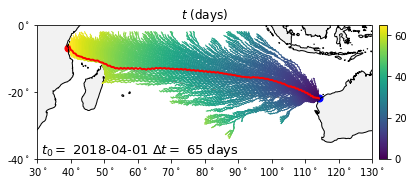

In [90]:
# plot trajectories as function of time
%matplotlib inline
titlem = '$t_0 = $ '+datet0.strftime('%Y-%m-%d')+' $\Delta t = $ '+str((datet-datet0).days)+' days'
fig,ax = plt_base_iteration(X0,Xt,xlims,ylims,20,10,title = '$t$ (days)')
fig,ax = plt_traject(fig,ax,Nhist,Xs,Xt,hide_all = False, hide_fast = False, traj_col = True)
ax.annotate(titlem, xy=(0.01, 0),xycoords='axes fraction', fontsize=13, horizontalalignment='left', verticalalignment='bottom')

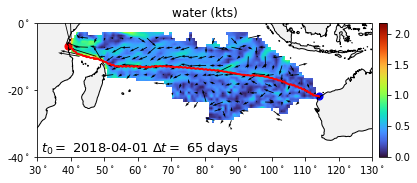

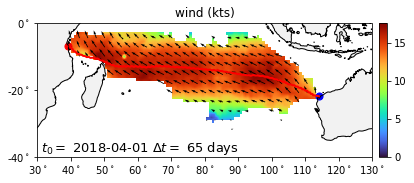

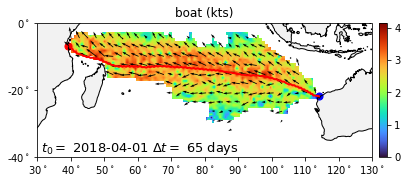

In [91]:
# plot wind water and boat speeds
%matplotlib inline
pVws  = np.concatenate(Vws)
pVas  = np.concatenate(Vas)
pVs   = np.concatenate(Vs)
pXs   = np.concatenate(Xs)

pintx = np.linspace(xlims[0],xlims[1],40*3)
pinty = np.linspace(ylims[0],ylims[1],15*3)

pintX,pintY = np.meshgrid(pintx,pinty)

idxkeep = np.zeros(pintX.shape).astype(bool)

_,_,ashape = alpha_shape_opt(pXs)
bdom = pdom.intersection(ashape)

for j in range(pintX.shape[0]):
    for i in range(pintX.shape[1]):
        if Point([pintX[j,i],pintY[j,i]]).intersects(bdom):
            idxkeep[j,i]=True

pintuws = griddata(pXs, pVws[:,0], (pintX, pintY), method='linear')*tokts; pintuws[~idxkeep]=np.nan
pintvws = griddata(pXs, pVws[:,1], (pintX, pintY), method='linear')*tokts; pintvws[~idxkeep]=np.nan

pintuas = griddata(pXs, pVas[:,0], (pintX, pintY), method='linear')*tokts; pintuas[~idxkeep]=np.nan
pintvas = griddata(pXs, pVas[:,1], (pintX, pintY), method='linear')*tokts; pintvas[~idxkeep]=np.nan

pintus = griddata(pXs, pVs[:,0], (pintX, pintY), method='linear')*tokts; pintus[~idxkeep]=np.nan
pintvs = griddata(pXs, pVs[:,1], (pintX, pintY), method='linear')*tokts; pintvs[~idxkeep]=np.nan

titlem = '$t_0 = $ '+datet0.strftime('%Y-%m-%d')+' $\Delta t = $ '+str((datet-datet0).days)+' days'

qidx = 3;
fig,ax = plt_base_iteration(X0,Xt,xlims,ylims,20,10,title='water (kts)')
plt.quiver(pintX[::qidx,::qidx],pintY[::qidx,::qidx],pintuws[::qidx,::qidx],pintvws[::qidx,::qidx])

dx = (pintx[1]-pintx[0])/2.
dy = (pinty[1]-pinty[0])/2.
extent = [pintx[0]-dx, pintx[-1]+dx, pinty[0]-dy, pinty[-1]+dy]
im = plt.imshow(np.flip(np.sqrt(pintuws**2+pintvws**2),0), extent=extent,interpolation = 'bilinear',cmap='turbo',vmin=0)
fig,ax = plt_traject(fig,ax,Nhist,Xs,Xt,hide_all=True)
cax     = fig.add_axes([ax.get_position().x1+0.015,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax) # Similar to fig.colorbar(im, cax = cax)
ax.annotate(titlem, xy=(0.01, 0),xycoords='axes fraction', fontsize=13, horizontalalignment='left', verticalalignment='bottom')
plt.show()
plt.close()

fig,ax = plt_base_iteration(X0,Xt,xlims,ylims,20,10,title='wind (kts)')
plt.quiver(pintX[::qidx,::qidx],pintY[::qidx,::qidx],pintuas[::qidx,::qidx],pintvas[::qidx,::qidx])

dx = (pintx[1]-pintx[0])/2.
dy = (pinty[1]-pinty[0])/2.
extent = [pintx[0]-dx, pintx[-1]+dx, pinty[0]-dy, pinty[-1]+dy]
im      = plt.imshow(np.flip(np.sqrt(pintuas**2+pintvas**2),0), extent=extent,interpolation = 'bilinear',cmap='turbo',vmin=0)
fig,ax  = plt_traject(fig,ax,Nhist,Xs,Xt,hide_all=True)
cax     = fig.add_axes([ax.get_position().x1+0.015,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax) # Similar to fig.colorbar(im, cax = cax)
ax.annotate(titlem, xy=(0.01, 0),xycoords='axes fraction', fontsize=13, horizontalalignment='left', verticalalignment='bottom')
plt.show()
plt.close()

fig,ax = plt_base_iteration(X0,Xt,xlims,ylims,20,10,title='boat (kts)')
plt.quiver(pintX[::qidx,::qidx],pintY[::qidx,::qidx],pintus[::qidx,::qidx],pintvs[::qidx,::qidx])
dx = (pintx[1]-pintx[0])/2.
dy = (pinty[1]-pinty[0])/2.
extent = [pintx[0]-dx, pintx[-1]+dx, pinty[0]-dy, pinty[-1]+dy]
im = plt.imshow(np.flip(np.sqrt(pintus**2+pintvs**2),0), extent=extent,interpolation = 'bilinear',cmap='turbo',vmin=0)
fig,ax = plt_traject(fig,ax,Nhist,Xs,Xt,hide_all=True)
cax     = fig.add_axes([ax.get_position().x1+0.015,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax) # Similar to fig.colorbar(im, cax = cax)
ax.annotate(titlem, xy=(0.01, 0),xycoords='axes fraction', fontsize=13, horizontalalignment='left', verticalalignment='bottom')
plt.show()
plt.close()

# 8. Cyclone probability

The cyclone probability is calculated per month per region. Within each region, the duration of cyclone occurrences is divided by the total duration of the time. 

<span style="color:red">Note that the current method does not include the cyclone index. Therefore, it can not distinguish cyclones.</span> In addition, the cyclone probability is not considered in the ocean row, yet.

# 8.1. Load cyclone data

In [176]:
# Dataset obtained from: https://www.ncei.noaa.gov/products/international-best-track-archive?name=ib-v4-access
dcycl = xr.open_dataset('//uniwa.uwa.edu.au/userhome/students8/23513098/My Documents/Rick/Work/RIOP/Scripts/Data/IBTrACS_SI_v04r00.nc') # load dataset
tend  = dcycl.time.max('date_time',skipna=True).values # get end date of cyclone

# select time window
tystart = 2000 # strating from year tystart
tyend   = 2021 # up and including year tyend

# get cyclone locations as function of time 
idxstorm = tend.astype('datetime64[Y]')>=np.array([str(tystart)],dtype='datetime64[Y]') # find all storms that ended after the year 2000
Ns       = np.sum(idxstorm) # count number of cyclones
time,lat,lon = dcycl.isel(storm=idxstorm).coords.values() # get route of cyclone
dfcycl = pd.DataFrame({'datet':time.values.flatten(),'lon':lon.values.flatten(),'lat':lat.values.flatten()}) # store in dataframe

# remove timesteps with NaN
idxkeep = np.logical_not(np.isnan(dfcycl.datet))
dfcycl  = dfcycl[idxkeep]

# remove timesteps outside time window
idxkeep = (dfcycl.datet.astype('datetime64[Y]').to_numpy() >= np.array([str(tystart)],dtype='datetime64[Y]')) & (dfcycl.datet.astype('datetime64[Y]').to_numpy() <= np.array([str(tyend)],dtype='datetime64[Y]'))
dfcycl  = dfcycl[idxkeep]

## 8.2.  Analysis

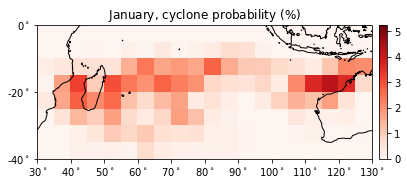

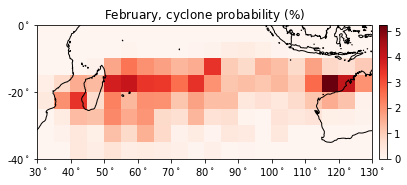

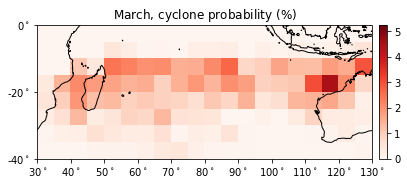

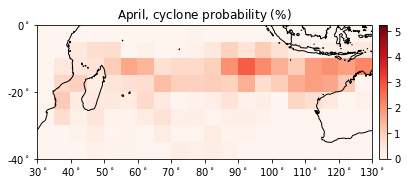

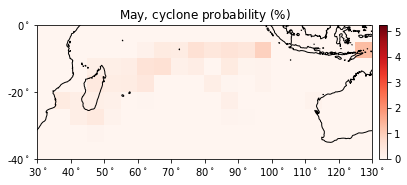

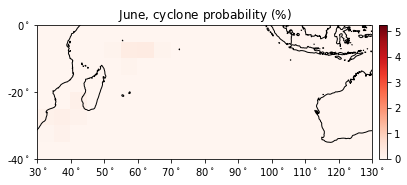

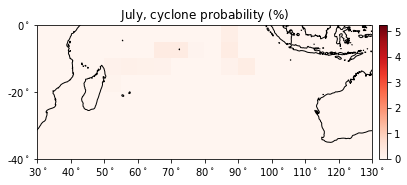

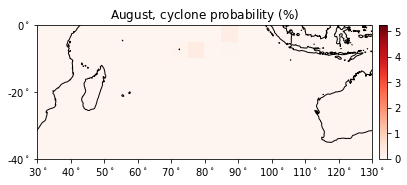

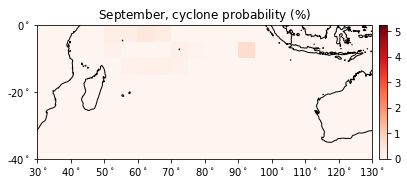

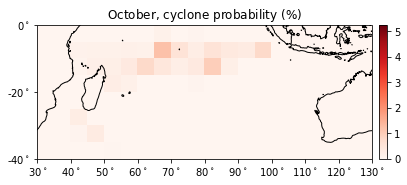

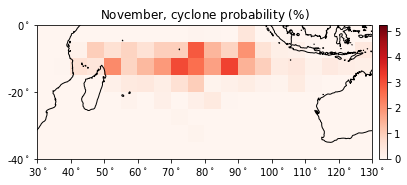

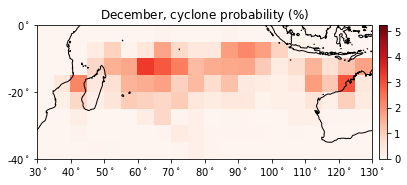

In [183]:
xedges = np.arange(15,185,5) # longitude spacing histogram
yedges = np.arange(-50,5,5) # latitude spacing histogram

months = pd.DatetimeIndex(dfcycl.datet).month.to_numpy() # month of occurance per data point

for i in range(12):
    imonth = i+1

    dt_totaldm = np.sum(pd.date_range(start='1/1/'+str(tystart), end='31/12/'+str(tyend-1)).month == imonth) # total number of days considered
    dt_totalhm = dt_totaldm*24 # total number of hours

    idxm  = months == imonth # cyclones in selected month
    latfm = dfcycl.lat[idxm] # latitude 
    lonfm = dfcycl.lon[idxm] # longitude 

    H, xedges, yedges = np.histogram2d(lonfm, latfm, bins=(xedges, yedges)) # make 2D histogram of cyclone occurance
    tdur = H.T*3 # duraction of cyclone occurance (timestep is 3 hours)
    Z = tdur/dt_totalhm*100 # calculate % of occurance
    X,Y = np.meshgrid(xedges[:-1]+np.diff(xedges)/2,yedges[:-1]+np.diff(yedges)/2) # create grid for histogram
    fig,ax = plt_base_simple(xlims,ylims,20,10) # create plot base
    im = plt_modified_imshow(X,Y,Z,ax,cb=True,cmap='Reds',interpolation='nearest',vmin=0,vmax=5.25) # draw imshow
    ax.set(xlim=[30,130],ylim=[-40,0],title=calendar.month_name[imonth]+', cyclone probability ($\%$)') # set labels
    plt.show()

# 9. Previous ocean rows
This section compares the model with the previous ocean rows conducted by Sarah Outen and by Erden Eruc. First, the GPS data of these rows are loaded in. Subsequently, the ocean model is forced to follow these routes. Then, the polar plots of the previous and simulated rows are compared. 

Note that the recorded locations of the previous rows are sampled daily. Therefore, to compare the previous and simulated rows with each other, we need to sample the simulated row to the same frequency of the previous ocean rows. 

# 9.1. Load trajectories previous rows
Load in GPS data, calculate boat speed and include the air and water speeds from the hindcast data.

In [184]:
def load_row_sarah(): # Load data of ocean row Sarah Outen
    kml_file = "//uniwa.uwa.edu.au/userhome/students8/23513098/My Documents/Rick/Work/RIOP/Scripts/Data/Track_Sarah_Outen.kml" # file directory

    gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' # configure kml reader 
    df = gpd.read_file(kml_file, driver='KML') # read kml file
    x  = df.geometry.x.values # set longitude values
    y  = df.geometry.y.values # set latitude values
    t  = pd.Series([datetime.strptime(re.search(r'\d{2}/\d{2}/\d{4} \d{2}:\d{2}:\d{2}', x).group(), '%d/%m/%Y %H:%M:%S') for x in df.Description]) # create time series

    dfS = pd.DataFrame({'datet':t,'lon':x,'lat':y}) # store in dataframe
    dfS = dfS.sort_values(by=['datet']).reset_index(drop=True) # sort by time
    return dfS

def load_row_erden(): # Load data of ocean row Erden Eruc
    tab     = pd.read_csv('//uniwa.uwa.edu.au/userhome/students8/23513098/My Documents/Rick/Work/RIOP/Scripts/Data/Track_Erden_Eruc.csv',encoding= 'unicode_escape') # file directory
    tstring = [x[x.find('-')+2:x.find('(')-1]+' '+x[x.find('(')+1:x.find(')')-4] for x in tab['Day/Date']] # get time as string
    tstring = [x.replace('\xa0',' ') for x in tstring] # clean up time strings
    t       = pd.to_datetime(tstring) # convert to datetime

    # convert latitude 
    deg       = np.array([re.split('[::]', x)[0] for x in tab.Latitude.values.astype(str)]).astype(int)
    minutes   = np.array([re.split('[::]', x)[1] for x in tab.Latitude.values.astype(str)]).astype(int)
    seconds   = np.array([re.split('[::]', x)[2][:-1] for x in tab.Latitude.values.astype(str)]).astype(int)
    direction = np.array([re.split('[::]', x)[2][-1] for x in tab.Latitude.values.astype(str)]).astype(str)
    y         = (deg + minutes/60 + seconds/(60*60)) * np.array([(-1 if x in ['W', 'S'] else 1) for x in direction])

    # convert longitude 
    deg       = np.array([re.split('[::]', x)[0] for x in tab.Longitude.values.astype(str)]).astype(int)
    minutes   = np.array([re.split('[::]', x)[1] for x in tab.Longitude.values.astype(str)]).astype(int)
    seconds   = np.array([re.split('[::]', x)[2][:-1] for x in tab.Longitude.values.astype(str)]).astype(int)
    direction = np.array([re.split('[::]', x)[2][-1] for x in tab.Longitude.values.astype(str)]).astype(str)
    x         = (deg + minutes/60 + seconds/(60*60)) * np.array([(-1 if x in ['W', 'S'] else 1) for x in direction])

    dfE = pd.DataFrame({'datet':t,'lon':x,'lat':y}) # store in dataframe
    dfE = dfE.sort_values(by=['datet']).reset_index(drop=True) # sort by time
    return dfE

# load data
dfS = load_row_sarah()
dfE = load_row_erden()

# calculate average boat speed
for df in [dfS,dfE]:
    N  = len(df) # number of data points
    ub = np.empty(N) # allocate boat speed longitudinal ub
    vb = np.empty(N) # allocate boat speed lateral vb
    for i in range(N-1): 
        geo_data = Geodesic.WGS84.Inverse(df.lat[i],df.lon[i],df.lat[i+1],df.lon[i+1]) # get geo data between points
        ds = geo_data['s12'] # distance between points
        dy = ds*np.cos(geo_data['azi1']/180*np.pi) # lateral distance per step (in m)
        dx = ds*np.sin(geo_data['azi1']/180*np.pi) # longitudinal distance per step (in m)
        dt = (df.datet[i+1]-df.datet[i])/np.timedelta64(1, 's') # time step (in s)
        ub[i] = dx/dt # boat speed longitudinal
        vb[i] = dy/dt # boat speed lateral
    ub[N-1] = np.nan # no boat speed for last point
    vb[N-1] = np.nan 
    df['ub'] = ub # include in dataframe
    df['vb'] = vb

# include water (current) and air (wind) speeds to dataframes of previous rows
for df in [dfS,dfE]: # loop over dataframes
    N = len(df) # number of data poitns
    
    # allocate speeds
    ua = np.empty(N) # longitudinal air
    va = np.empty(N) # lateral air
    uw = np.empty(N) # longitudinal water
    vw = np.empty(N) # lateral water

    for i in range(N):
        datet = df.datet[i]
        lon = df.lon[i]
        lat = df.lat[i]

        # air velocity
        Dalat    = dswind.latitude.values # get coordinates of hindcast dataset
        Dalon    = dswind.longitude.values
        Dadatet    = dswind.time.values
        Dadatetidx = np.argmin(np.abs(Dadatet-datet.to_datetime64())) # find nearest index in time

        Dua = dswind.northward_wind[Dadatetidx,0,:,:].values 
        Dva = dswind.eastward_wind [Dadatetidx,0,:,:].values 

        Dalatidx = np.argmin(np.abs(Dalat-lat)) # find nearest index in longitude
        Dalonidx = np.argmin(np.abs(Dalon-lon)) # find nearest index in latitude
        ua[i] = Dua[Dalatidx,Dalonidx]
        va[i] = Dva[Dalatidx,Dalonidx]

        # water velocity
        Dwlat   = dswater.latitude.values # get coordinates of hindcast dataset
        Dwlon   = dswater.longitude.values
        Dwdatet    = dswater.time.values
        Dwdatetidx = np.argmin(np.abs(Dwdatet-datet.to_datetime64())) # find nearest index in time

        Duw = dswater.uo[Dwdatetidx,0,:,:].values
        Dvw = dswater.vo[Dwdatetidx,0,:,:].values

        Dwlatidx = np.argmin(np.abs(Dwlat-lat)) # find nearest index in latitude
        Dwlonidx = np.argmin(np.abs(Dwlon-lon)) # find nearest index in longitude
        uw[i] = Duw[Dwlatidx,Dwlonidx]
        vw[i] = Dvw[Dwlatidx,Dwlonidx]
        
    # add to dataframe
    df['uw'] = uw
    df['vw'] = vw
    df['ua'] = ua
    df['va'] = va

## 9.2. Analysis previous ocean rows
Provide overview plots of previous ocean rows.

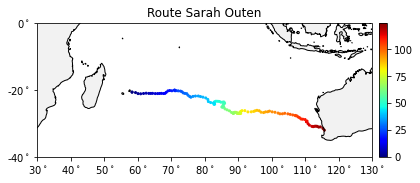

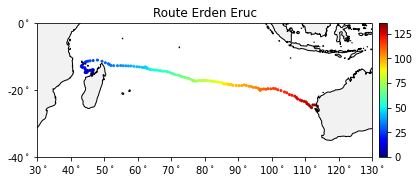

In [188]:
# create figure with rowing route and duration
dfr   = [dfS,dfE]
namer = ['Sarah Outen','Erden Eruc']

for i in range(len(dfr)):
    df   = dfr[i]
    name = namer[i]
    
    xlims = [30,130] 
    ylims = [-40,0]
    fig,ax = plt_base_simple(xlims,ylims,20,10)
    plot   = plt.scatter(df.lon,df.lat,4,c=(df.datet[len(df.datet)-1]-df.datet)/np.timedelta64(1, 'D'),cmap='jet')
    cax    = fig.add_axes([ax.get_position().x1+0.015,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(plot, cax=cax) 
    ax.set_title('Route '+name)
    plt.show(); plt.close()

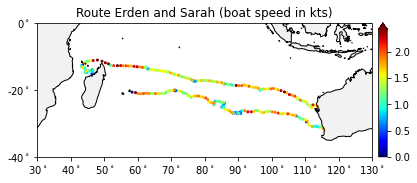

In [189]:
# create figure with rowing route and boat speed (averaged per day) of all previous rows
fig,ax = plt_base_simple(xlims,ylims,20,10)
for df in [dfE,dfS]:
    plot = plt.scatter(df.lon,df.lat,4,c=np.sqrt(df.ub**2+df.vb**2)*tokts,cmap='jet', vmin=0, vmax=1.25*tokts)
cax = fig.add_axes([ax.get_position().x1+0.015,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(plot, cax=cax,extend='max') # Similar to fig.colorbar(im, cax = cax)
ax.set_title('Route Erden and Sarah (boat speed in kts)')
# plt.savefig(os.getcwd()+'\\Plots'+'\\'+'Routes both speed'+'.png', dpi=300, bbox_inches='tight') # save figure
plt.show(); plt.close()

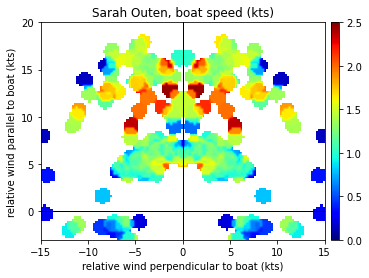

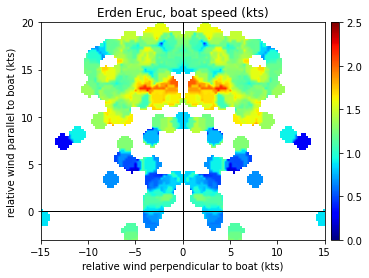

In [191]:
dfr   = [dfS,dfE]
namer = ['Sarah Outen','Erden Eruc']

for i in range(len(dfr)):
    df   = dfr[i]
    
    ubrel = df.ub-df.uw
    vbrel = df.vb-df.vw
    
    uarel = df.ua-df.uw
    varel = df.va-df.vw

    theta_rel = np.arctan(ubrel/vbrel)
    theta_a   = np.arctan(uarel/varel)
    theta_arel = theta_a-theta_rel
    speedb = np.sqrt(ubrel**2+vbrel**2)
    speeda = np.sqrt(uarel**2+varel**2)
    speeda_along = np.cos(theta_arel) * speeda
    speeda_perp = np.sin(theta_arel) * speeda
    
    x = np.concatenate([-np.abs(speeda_perp),np.abs(speeda_perp)])*tokts
    y = np.tile(speeda_along,2)*tokts
    z = np.tile(speedb,2)*tokts


    X,Y = np.meshgrid(np.arange(-15,15.25,0.25),np.arange(-3,20.25,0.25))
    Nx = X.shape[1]
    Ny = X.shape[0]

    Z = np.empty([Ny,Nx])
    Z.fill(np.nan)

    dismin = 1
    
    fig,ax = plt.subplots()

    for ii in range(Nx):
        for jj in range(Ny):
            xp = X[jj,ii]
            yp = Y[jj,ii]

            dis = np.sqrt((xp-x)**2+(yp-y)**2)
            if np.any(dis<=dismin):
                Z[jj,ii] = np.nanmean(z[dis<=dismin])
    plt.axvline(x=0,c='black',linewidth=1)
    plt.axhline(y=0,c='black',linewidth=1)

    Zmax = 2.5
    
    dx = (X[0,1]-X[0,0])/2.
    dy = (Y[1,0]-Y[0,0])/2.
    extent = [X[0,0]-dx, X[0,-1]+dx, Y[0,0]-dy, Y[-1,0]+dy]
    
    plt.imshow(np.flip(Z,0),cmap='jet',interpolation='bilinear',extent=extent,vmin=0,vmax=Zmax)
    
    # add colorbar
    cax = fig.add_axes([ax.get_position().x1+0.015,ax.get_position().y0,0.02,ax.get_position().height])
    norm = mpl.colors.Normalize(vmin=0, vmax=Zmax)
    cb = mpl.colorbar.ColorbarBase(cax,cmap='jet', norm=norm)
       
    ax.set(xlabel='relative wind perpendicular to boat (kts)',ylabel='relative wind parallel to boat (kts)',title=namer[i]+', boat speed (kts)',xlim=[-15,15],ylim=[-3,20])

# 9.3 Compare previous rows with model

<IPython.core.display.Javascript object>


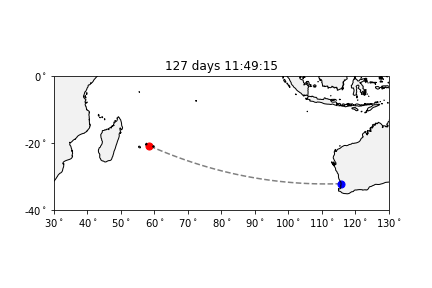

<IPython.core.display.Javascript object>


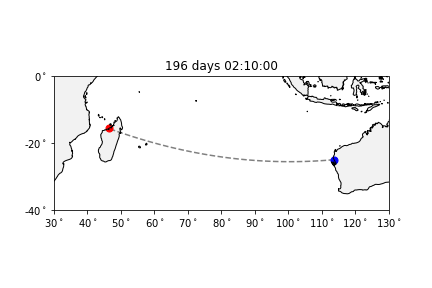

In [320]:
# compare to previous ocean row
dfr   = [dfS,dfE]
namer = ['Sarah Outen','Erden Eruc']
for idx_row in range(len(dfr)):
    df   = dfr[idx_row]
    
    # model configuration
    vperf = 2/tokts # boat velocity in perfect conditions [m/s]

    datet0    = df.datet[0] # starting datetime
    tod_start = ['06:00:00','14:00:00'] # start rowing - time of day
    tod_stop  = ['12:00:00','20:00:00'] # stop rowing - time of day

    imax = 1000 # maximum number of iterations

    phir = np.array([0]) # angle offsets to target

    # intialize model
    # load in path of previous rows
    Xa_pr = np.vstack([df.lon.to_numpy(),df.lat.to_numpy()]).T # all previous row locations [deg]
    N_pr = len(df) # total number of locations

    # calculate force from velocity in perfect conditions
    Frmag = (Ga+Gw)*vperf**2 # calculate rowing force magnitude from perfect conditions [N]
    Pr    = Frmag*vperf # rowing power [W]
    int0,introw,intdur,intN = interval_activity(tod_start,tod_stop) # row activity

    # start location
    lon0   = df.lon[0]
    lat0   = df.lat[0]
    X0     = np.array([lon0,lat0])

    # target
    latt   = df.lat[len(df)-1]
    lont   = df.lon[len(df)-1]
    Xt     = np.array([lont,latt])
    rt0    = Geodesic.WGS84.Inverse(X0[1],X0[0],Xt[1],Xt[0])['s12'] # distance to target
    rtmin  = np.max([np.max(intdur[introw])*vperf*1.5,100000]) # threshold of distance till target [m]

    # store values during iterations
    jstep  = 1 # store values after every jstep
    datets = np.empty([int(np.ceil(imax/jstep))]) # allocate to store time
    datets.fill(np.nan) 

    # intialize 
    N       = 1; # number of starting points
    Nr      = np.arange(0,N).astype(int) # make range of starting points
    Xa      = np.empty([N,2]) # allocate all locations
    Xa[0,:] = X0 # location 
    i       = 0 # iteration
    j       = 0 # storage iteration
    k,dt    = interval0(datet0,int0) # k: idx interval, dt: timestep interval
    rto     = np.array([Geodesic.WGS84.Inverse(x[1],x[0],Xt[1],Xt[0])['s12'] for x in Xa]) # geodesic distance to target
    datet   = datet0 # datetime series

    # rowing directions 
    Nphir   = len(phir) # number of angle offsets

    # dataset coordinates
    Dalat   = dswind.latitude.values
    Dalon   = dswind.longitude.values
    Dwlat   = dswater.latitude.values
    Dwlon   = dswater.longitude.values
    Dadatet = dswind.time.values

    # load hindcast data 
    Dua,Dva,Duw,Dvw = hindcast_slice_data(datet,dswind,dswater) # get slice of hindcast air and water velocities
    Va,Vw = hindcast_get_vel(Dua,Dva,Duw,Dvw,X0,Dalat,Dalon,Dwlat,Dwlon) # get air and water velocities at location of boat

    # store variables
    Xs     = []; Xs.append(Xa)
    Vas    = []; Vas.append(np.array([Va]))
    Vws    = []; Vws.append(np.array([Vw]))
    Vs     = []; Vs.append(np.array([[np.nan,np.nan]]))
    datets = []; datets.append(datet.to_numpy())
    Nhist  = []; Nhist.append(None)

    # create plot
    %matplotlib notebook
    fig,ax = plt_base_iteration(X0,Xt,[30,130],[-40,0],20,10,title = pd.to_timedelta(np.round((datet-datet0).total_seconds()),'s'))
    pltraj = ax.plot(Xa[:,0],Xa[:,1],'o',color='black',markersize=1.5)

    while (i < (imax-1)) & np.all(rto > rtmin): # start loop
        i = i+1  # next iteration

        # rowing activity
        rowt = introw[k] # check rowing activity options
        if rowt == True: # if rowing
            No   = 1 # only row
            phio = np.array([phir]) # rowing direction options
            rowo = np.array([True]) # rowing options
            anco = np.array([False]) # anchor options
        if rowt == False: # if resting
            No   = 1 # only anchor
            phio = np.array([np.nan]) # rowing direction options
            rowo = np.array([False]) # rowing options
            anco = np.array([True]) # anchor options

        # allocate all new locations and velocities per time step
        Xaold  = Xa 
        Xa     = np.empty([N*No,2])
        Vai    = np.empty([N*No,2])
        Vwi    = np.empty([N*No,2])
        Vi     = np.empty([N*No,2])
        Nhisti = np.zeros([N*No]).astype(int)

        # load hindcast data 
        Dua,Dva,Duw,Dvw = hindcast_slice_data(datet,dswind,dswater) # get slice of hindcast air and water velocities

        for ii in range(N): # loop over every starting location  
            X = np.copy(Xaold[ii,:]) # get starting location

            # air and water velocity
            Va,Vw = hindcast_get_vel(Dua,Dva,Duw,Dvw,X,Dalat,Dalon,Dwlat,Dwlon) # get air and water velocities at location of boat

            for jj in range(No): # loop over every activity option

                Nhisti[ii*No+jj] = Nr[ii] # get starting point idx

                # get option details
                phi = phio[jj] 
                row = rowo[jj]
                anc = anco[jj]

                # direction
                if row: # when rowing
                    # find rowing direction based on previous row
                    rt_pr = np.array([Geodesic.WGS84.Inverse(x[1],x[0],X[1],X[0])['s12'] for x in Xa_pr]) # find distance between boat and previous row locations
                    idxpr = np.argmin(rt_pr) # find which location is closest to boat

                    if idxpr == N_pr-1: # if last location is closest
                        idxpr_aim = idxpr # row towards destination
                    else: # otherwise
                        idxpr_aim = idxpr+1 # row towards next stop

                    # rowing direction
                    theta = Geodesic.WGS84.Inverse(X[1],X[0],Xa_pr[idxpr_aim,1],Xa_pr[idxpr_aim,0])['azi1'] # find angle towards next stop
                    ed    = (np.array([np.sin(theta/180*np.pi),np.cos(theta/180*np.pi)])).flatten() # convert angle into rowing directions in 2D

                else: # when resting 
                    if Va.dot(Va)!=0: # if there is wind
                        ed    = (Va/np.sqrt(Va.dot(Va))).flatten() # boat turns in direction of wind
                    else: # if there is no wind
                        # find rowing direction based on previous row
                        rt_pr = np.array([Geodesic.WGS84.Inverse(x[1],x[0],X[1],X[0])['s12'] for x in Xa_pr]) # find distance between boat and previous row locations
                        idxpr = np.argmin(rt_pr) # find which location is closest to boat

                        if idxpr == N_pr-1: # if last location is closest
                            idxpr_aim = idxpr # row towards destination
                        else: # otherwise
                            idxpr_aim = idxpr+1 # row towards next stop

                        # rowing direction
                        theta = Geodesic.WGS84.Inverse(X[1],X[0],Xa_pr[idxpr_aim,1],Xa_pr[idxpr_aim,0])['azi1'] # find angle towards next stop
                        ed    = (np.array([np.sin(theta/180*np.pi),np.cos(theta/180*np.pi)])).flatten() # convert angle into rowing directions in 2D

                # calculate boat velocity
                V = fsolve(total_force,list(ed*(vperf*int(row)+Vw*0.2+Va*0.1)),args=(Vw,Va,ed,Frmag,row,anc,Gw,GwA,Ga),xtol=1e-04)

                # update velocity and position
                vmag = np.sqrt(V[0]**2+V[1]**2)
                if vmag != 0: # only update X if there is a V
                    azi1 = angle_between([0,1],V)
                    s12  = vmag*dt
                    Xnew = np.array(list(map(Geodesic.WGS84.Direct(X[1],X[0],azi1,s12).get, ['lon2','lat2']))) # new location
                else:
                    Xnew = np.copy(X)

                # get distances from start and end
                r0 = Geodesic.WGS84.Inverse(Xnew[1],Xnew[0],X0[1],X0[0])['s12'] # distance to starting point
                rt = Geodesic.WGS84.Inverse(Xnew[1],Xnew[0],Xt[1],Xt[0])['s12'] # distance to target point

                if np.logical_not(Point([Xnew[0],Xnew[1]]).intersects(pdom)) & (r0 > rtmin) & (rt > rtmin): #if on land
                    Xnew  = np.array([np.nan,np.nan])
                else: # if in allowed region
                    Xnew  = Xnew    

                # store values
                Xa [ii*No+jj,:] = Xnew 
                Vai[ii*No+jj,:] = Va
                Vwi[ii*No+jj,:] = Vw
                Vi [ii*No+jj,:] = V

        # distance to target
        rto = np.array([Geodesic.WGS84.Inverse(x[1],x[0],Xt[1],Xt[0])['s12'] for x in Xa])# geodesic distance to target
        N   = Xa.shape[0]
        Nr  = np.arange(0,N)

        # update datet
        datet = datet+pd.to_timedelta(dt,'s')   

        # store values
        Xs   .append(Xa)
        Nhist.append(Nhisti)
        Vas  .append(Vai)
        Vws  .append(Vwi)
        Vs   .append(Vi)
        datets.append(datet.to_numpy())

        # for next step
        k  = (k+1)%intN
        dt = intdur[k]

        print('Iteration: '+str(round(i/imax*1000)/10)+'%, Distance: '+str(round((1-np.min(rto)/rt0)*1000)/10)+'%', end='\r')

        if i%5 == 0: # plot locations
            pltrajpop = pltraj.pop(0)
            pltrajpop.remove()
            pltraj    = ax.plot(Xa[:,0],Xa[:,1],'o',color='black',markersize=1.5)
            fig.canvas.draw()
            ax.set_title(pd.to_timedelta(np.round((datet-datet0).total_seconds()),'s'))
    plt.show()

    dfM = pd.DataFrame({'datet':np.array(datets),\
                        'lon':np.concatenate(Xs)[:,0],\
                        'lat':np.concatenate(Xs)[:,1],\
                       'ub':np.append(np.concatenate(Vs)[1:,0],np.nan),\
                       'vb':np.append(np.concatenate(Vs)[1:,1],np.nan),\
                       'uw':np.append(np.concatenate(Vws)[1:,0],np.nan),\
                       'vw':np.append(np.concatenate(Vws)[1:,1],np.nan),\
                       'ua':np.append(np.concatenate(Vas)[1:,0],np.nan),\
                       'va':np.append(np.concatenate(Vas)[1:,1],np.nan)}) # store in dataframe

    dfM = dfM.groupby(dfM.datet.dt.date).first()
    
    if namer[idx_row]=='Sarah Outen':
        dfSM = dfM.copy()
    elif namer[idx_row]=='Erden Eruc': 
        dfEM = dfM.copy()

%matplotlib inline

In [321]:
# calculate average boat speed
for df in [dfSM,dfEM]:
    N  = len(df) # number of data points
    ub = np.empty(N) # allocate boat speed longitudinal ub
    vb = np.empty(N) # allocate boat speed lateral vb
    for i in range(N-1): 
        geo_data = Geodesic.WGS84.Inverse(df.lat[i],df.lon[i],df.lat[i+1],df.lon[i+1]) # get geo data between points
        ds = geo_data['s12'] # distance between points
        dy = ds*np.cos(geo_data['azi1']/180*np.pi) # lateral distance per step (in m)
        dx = ds*np.sin(geo_data['azi1']/180*np.pi) # longitudinal distance per step (in m)
        dt = (df.datet[i+1]-df.datet[i])/np.timedelta64(1, 's') # time step (in s)
        ub[i] = dx/dt # boat speed longitudinal
        vb[i] = dy/dt # boat speed lateral
    ub[N-1] = np.nan # no boat speed for last point
    vb[N-1] = np.nan 
    df['ub'] = ub # include in dataframe
    df['vb'] = vb

In [334]:
df.datet[len(df.datet)-1]-df.datet

0     124 days 15:48:07
1     123 days 15:47:41
2     122 days 12:48:11
3     121 days 15:48:25
4     120 days 15:48:26
             ...       
121     3 days 15:46:06
122     2 days 15:53:51
123     1 days 15:15:11
124     0 days 15:15:15
125     0 days 00:00:00
Name: datet, Length: 126, dtype: timedelta64[ns]

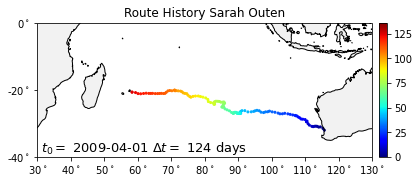

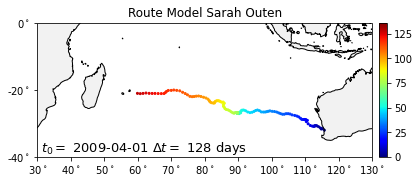

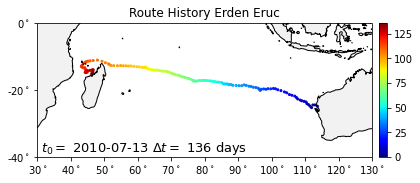

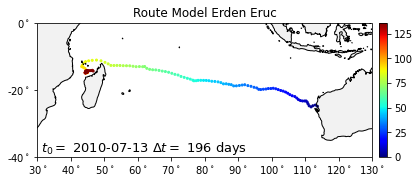

In [339]:
# create figure with rowing route and duration
dfr   = [dfS,dfSM,dfE,dfEM]
namer = ['History Sarah Outen','Model Sarah Outen','History Erden Eruc','Model Erden Eruc']

for i in range(len(dfr)):
    df   = dfr[i]
    name = namer[i]
    
    xlims = [30,130] 
    ylims = [-40,0]
    fig,ax = plt_base_simple(xlims,ylims,20,10)
    plot   = plt.scatter(df.lon,df.lat,4,c=(df.datet-df.datet[0])/np.timedelta64(1, 'D'),cmap='jet', vmin=0, vmax=136)
    cax    = fig.add_axes([ax.get_position().x1+0.015,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(plot, cax=cax) 
    titlem = '$t_0 = $ '+df.datet[0].strftime('%Y-%m-%d')+' $\Delta t = $ '+str((df.datet[len(df)-1]-df.datet[0]).days)+' days'
    ax.annotate(titlem, xy=(0.01, 0),xycoords='axes fraction', fontsize=13, horizontalalignment='left', verticalalignment='bottom')

    ax.set_title('Route '+name)
    plt.show(); plt.close()

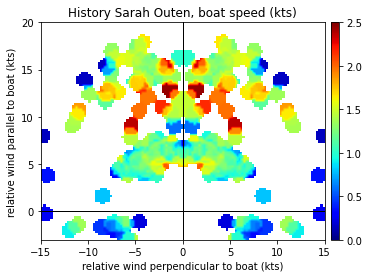

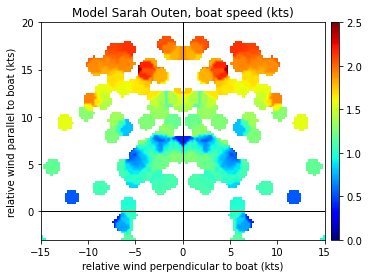

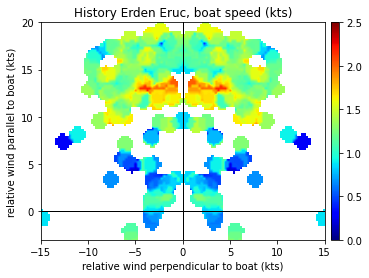

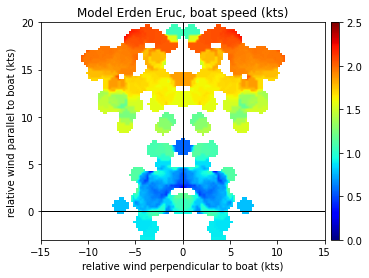

In [327]:
dfr   = [dfS,dfSM,dfE,dfEM]
namer = ['History Sarah Outen','Model Sarah Outen','History Erden Eruc','Model Erden Eruc']
for i in range(len(dfr)):
    df   = dfr[i]
    
    ubrel = df.ub-df.uw
    vbrel = df.vb-df.vw
    
    uarel = df.ua-df.uw
    varel = df.va-df.vw

    theta_rel = np.arctan(ubrel/vbrel)
    theta_a   = np.arctan(uarel/varel)
    theta_arel = theta_a-theta_rel
    speedb = np.sqrt(ubrel**2+vbrel**2)
    speeda = np.sqrt(uarel**2+varel**2)
    speeda_along = np.cos(theta_arel) * speeda
    speeda_perp = np.sin(theta_arel) * speeda
    
    x = np.concatenate([-np.abs(speeda_perp),np.abs(speeda_perp)])*tokts
    y = np.tile(speeda_along,2)*tokts
    z = np.tile(speedb,2)*tokts


    X,Y = np.meshgrid(np.arange(-15,15.25,0.25),np.arange(-3,20.25,0.25))
    Nx = X.shape[1]
    Ny = X.shape[0]

    Z = np.empty([Ny,Nx])
    Z.fill(np.nan)

    dismin = 1
    
    fig,ax = plt.subplots()

    for ii in range(Nx):
        for jj in range(Ny):
            xp = X[jj,ii]
            yp = Y[jj,ii]

            dis = np.sqrt((xp-x)**2+(yp-y)**2)
            if np.any(dis<=dismin):
                Z[jj,ii] = np.nanmean(z[dis<=dismin])
    plt.axvline(x=0,c='black',linewidth=1)
    plt.axhline(y=0,c='black',linewidth=1)

    Zmax = 2.5
    
    dx = (X[0,1]-X[0,0])/2.
    dy = (Y[1,0]-Y[0,0])/2.
    extent = [X[0,0]-dx, X[0,-1]+dx, Y[0,0]-dy, Y[-1,0]+dy]
    
    plt.imshow(np.flip(Z,0),cmap='jet',interpolation='bilinear',extent=extent,vmin=0,vmax=Zmax)
    
    # add colorbar
    cax = fig.add_axes([ax.get_position().x1+0.015,ax.get_position().y0,0.02,ax.get_position().height])
    norm = mpl.colors.Normalize(vmin=0, vmax=Zmax)
    cb = mpl.colorbar.ColorbarBase(cax,cmap='jet', norm=norm)
       
    ax.set(xlabel='relative wind perpendicular to boat (kts)',ylabel='relative wind parallel to boat (kts)',title=namer[i]+', boat speed (kts)',xlim=[-15,15],ylim=[-3,20])